 <span style="color: purple; font-weight: bold; font-size:26px"> Check if any models performs better than the naive classifier </span>


Let's start by importing some libs

In [30]:
# data analysis
import pandas as pd
import numpy as np
import random

# visualisations
import seaborn 
import matplotlib.pyplot as plt
%matplotlib inline

# models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
import pickle # for saving the model

# preprocesing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.impute import KNNImputer

# just out of curiosity
import time


Now, let's define some helper functions!


In [3]:
# let's define some helper functions:

def plot_models_acc(dict, naive_classifier):
    labels = tuple(dict.keys())
    y_pos = np.arange(len(labels))
    values = [dict[n]['accuracy'] for n in dict]
    plt.bar(y_pos, values, align='center', alpha=0.5)
    plt.xticks(y_pos, labels,rotation='vertical')
    plt.ylabel('accuracy')
    plt.title('Accuracy of different models')
    # add a horizontal line at naive_classfier
    plt.axhline(y=naive_classifier, color='r', linestyle='-', label='Naive Classifier')
    plt.legend(loc='lower right')
    
    plt.show()

    
# checking the distribution of the features :)
def feature_dist(dataframe):
    col_num = len(dataframe.columns)
    from_to_ind = [(i, i+6) for i in range(0, col_num, 6)]

    for i, j in from_to_ind:
        if j >= col_num:
            if col_num - 1 == i:
                dataframe.iloc[:, i].hist(figsize=(11,11))
            else:
                dataframe.iloc[:, i:col_num-1].hist(layout=(1,col_num - 1 - i), figsize=(11,11))
        else:
            dataframe.iloc[:, i:j].hist(layout=(2,3), figsize=(11,11))
            
            
def conf_mat(grid_search: GridSearchCV, Y_test):
    # construction confusion matrix
    outcome_class_labels = ['Red', 'Draw', 'No contest', 'Blue']
    cm = confusion_matrix(
        Y_test, 
        grid_search.predict(X_test),
        labels = outcome_class_labels
    )

    # create heatmap
    seaborn.heatmap(
        cm, 
        annot=True, 
        cmap='Blues', 
        xticklabels=outcome_class_labels,
        yticklabels=outcome_class_labels,
        fmt='d')

    # add labels
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    return cm

### Importing data
Let's import our data now. It will most likely change, since the older data seems to be a little weird. For example, most of the winners are on the red side, most of some data is missing etc.

In [31]:
data = pd.read_excel("./UFCdata/datasets/UFC_complete_averages.xlsx")
data = data.sort_values('Event_Date', ascending=True).reset_index(drop=True)
data = data.replace(['--', '---'], pd.NA)[3000:] # also just for now, but starting from 3000's row is a nice tradeoff
# between a lower naive classifier accuracy and the completeness of the data
# data = data.dropna() # absolutely not final!!!!!!!! xD


In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4108 entries, 3000 to 7107
Columns: 181 entries, Column1 to B_Closing_Odds
dtypes: bool(1), datetime64[ns](1), float64(138), int64(28), object(13)
memory usage: 5.6+ MB


In [33]:
data.describe()

Column1   Unnamed: 0  R_Height_cm  R_Weight_kg      R_Reach  \
count  4108.000000  4108.000000  4108.000000  4108.000000  4061.000000   
mean   3550.956426  3550.956426   177.403666    73.669208   181.975582   
std    2005.657694  2005.657694     9.359153    16.223511    11.444736   
min      31.000000    31.000000   152.400000    52.154195   147.320000   
25%    1865.750000  1865.750000   170.180000    61.224490   172.720000   
50%    3515.500000  3515.500000   177.800000    70.294785   182.880000   
75%    5271.250000  5271.250000   185.420000    83.900227   190.500000   
max    7096.000000  7096.000000   210.820000   120.181406   213.360000   

             R_Age  R_Average_Knockdowns  \
count  4108.000000           4108.000000   
mean     31.085686              0.243887   
std       4.294430              0.299948   
min      18.000000              0.000000   
25%      28.000000              0.000000   
50%      31.000000              0.166667   
75%      34.000000              0.375000   
max      46.000000              3.000000   

       R_Average_Significant_Strikes_Attempted  \
count                              4108.000000   
mean                                 82.547674   
std                                  47.721426   
min                                   0.000000   
25%                                  51.000000   
50%                                  80.333333   
75%                                 110.934375   
max                                 367.000000   

       R_Average_Significant_Strikes_Landed  R_Significant_Strikes_%_Landed  \
count                           4108.000000                     4108.000000   
mean                              37.007383                        0.427931   
std                               21.299890                        0.147445   
min                                0.000000                        0.000000   
25%                               23.270833                        0.387942   
50%                               35.750000                        0.445769   
75%                               49.203571                        0.504682   
max                              189.000000                        1.000000   

       ...  B_Opp_Significant_Strikes_in_Clinch_%_Landed  \
count  ...                                   4108.000000   
mean   ...                                      0.534704   
std    ...                                      0.314520   
min    ...                                      0.000000   
25%    ...                                      0.408170   
50%    ...                                      0.642857   
75%    ...                                      0.750000   
max    ...                                      1.000000   

       B_Opp_Average_Significant_Strikes_on_Ground_Attempted  \
count                                        4108.000000       
mean                                            5.242350       
std                                             7.758324       
min                                             0.000000       
25%                                             0.000000       
50%                                             3.000000       
75%                                             7.000000       
max                                           141.000000       

       B_Opp_Average_Significant_Strikes_on_Ground_Landed  \
count                                        4108.000000    
mean                                            3.662517    
std                                             5.452937    
min                                             0.000000    
25%                                             0.000000    
50%                                             2.000000    
75%                                             4.883523    
max                                            84.000000    

       B_Opp_Significant_Strikes_on_Ground_%_Landed  Number_of_Rounds  \
count                                   410

In [34]:
data.describe(include=['O'])

Event_Name          Event_Location Fight_Weight  \
count                           4108                    4108         4108   
unique                           347                     118           10   
top     UFC 286: Edwards vs. Usman 3  Las Vegas, Nevada, USA  Lightweight   
freq                              15                    1438          621   

       Fight_Gender         R_Name  R_Stance       B_Name  B_Stance  \
count          4108           4108      4097         4108      4082   
unique            2           1193         3         1349         3   
top            Male  Derrick Lewis  Orthodox  Angela Hill  Orthodox   
freq           3485             18      3052           16      2970   

          Time_Format    Referee     Conclusion_Method Winner Underdog  
count            4108       4085                  4108   4108     4108  
unique              3        153                    10      4        3  
top     3 Rnd (5-5-5)  Herb Dean  Decision - Unanimous    Red   No one  
freq             3686        592                  1535   2317     3850

In [24]:
data.head()

Column1  Unnamed: 0                                         Event_Name  \
2500     5645        5645                    UFC 167: St-Pierre vs Hendricks   
2501     5651        5651                    UFC 167: St-Pierre vs Hendricks   
2502     5945        5945  The Ultimate Fighter: Team Rousey vs. Team Tat...   
2505     5940        5940  The Ultimate Fighter: Team Rousey vs. Team Tat...   
2515     1259        1259                   UFC Fight Night: Hunt vs Bigfoot   

     Event_Date                   Event_Location       Fight_Weight  \
2500 2013-11-16           Las Vegas, Nevada, USA  Light Heavyweight   
2501 2013-11-16           Las Vegas, Nevada, USA       Middleweight   
2502 2013-11-30           Las Vegas, Nevada, USA      Featherweight   
2505 2013-11-30           Las Vegas, Nevada, USA        Lightweight   
2515 2013-12-06  Brisbane, Queensland, Australia  Light Heavyweight   

      Fight_Title_Bout Fight_Gender           R_Name  R_Height_cm  ...  \
2500             False         Male     Rashad Evans       182.88  ...   
2501             False         Male        Ed Herman       185.42  ...   
2502             False         Male  Akira Corassani       172.72  ...   
2505             False         Male     Gray Maynard       175.26  ...   
2515             False         Male       Ryan Bader       187.96  ...   

      Last_Round_Duration    Time_Format         Referee  \
2500                  245  3 Rnd (5-5-5)       Herb Dean   
2501                  300  3 Rnd (5-5-5)     Kim Winslow   
2502                   25  3 Rnd (5-5-5)  Mario Yamasaki   
2505                  158  3 Rnd (5-5-5)    Yves Lavigne   
2515                  300  3 Rnd (5-5-5)      John Sharp   

         Conclusion_Method  Winner  Underdog  R_Open_Odds  B_Open_Odds  \
2500                KO/TKO     Red    No one       -230.0        170.0   
2501  Decision - Unanimous    Blue    No one        145.0       -185.0   
2502                    DQ     Red    No one        190.0       -270.0   
2505                KO/TKO    Blue    No one        100.0       -140.0   
2515  Decision - Unanimous     Red    No one       -585.0        385.0   

      R_Closing_Odds  B_Closing_Odds  
2500          -240.0           180.0  
2501           155.0          -185.0  
2502           170.0          -210.0  
2505          -130.0           100.0  
2515          -570.0           420.0  

[5 rows x 181 columns]

### Naive classifier

The naive classifier that would be the least we should beat is the proportion of Red Winners to all fights outcomes, since it's the most common result.

The naive classifier accuracy is:  0.5640214216163584


c:\users\mewash\desktop\datascienceprojectpython\myenv\lib\site-packages\pandas\plotting\_matplotlib\tools.py:227: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(**fig_kw)


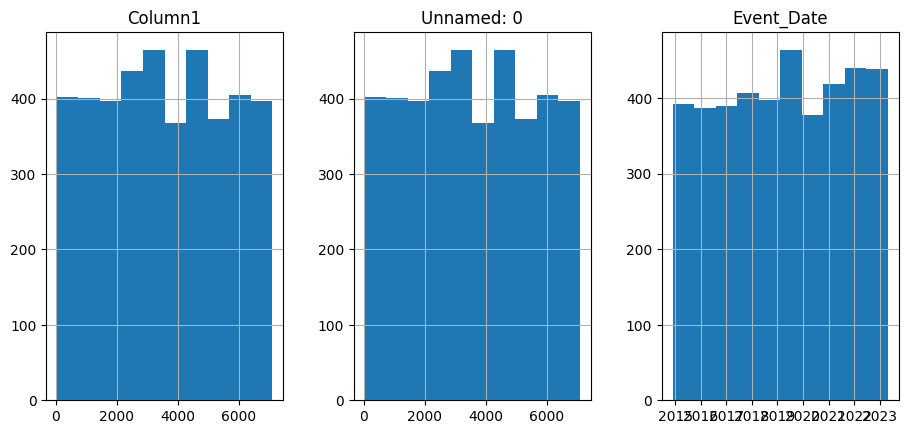

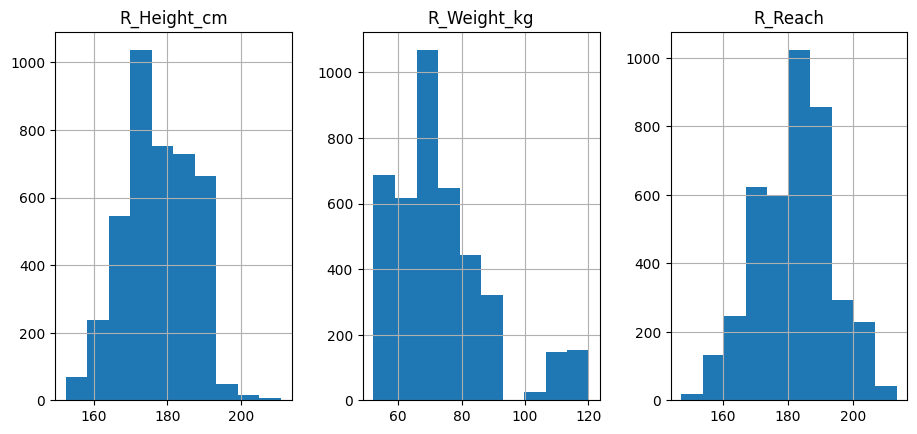

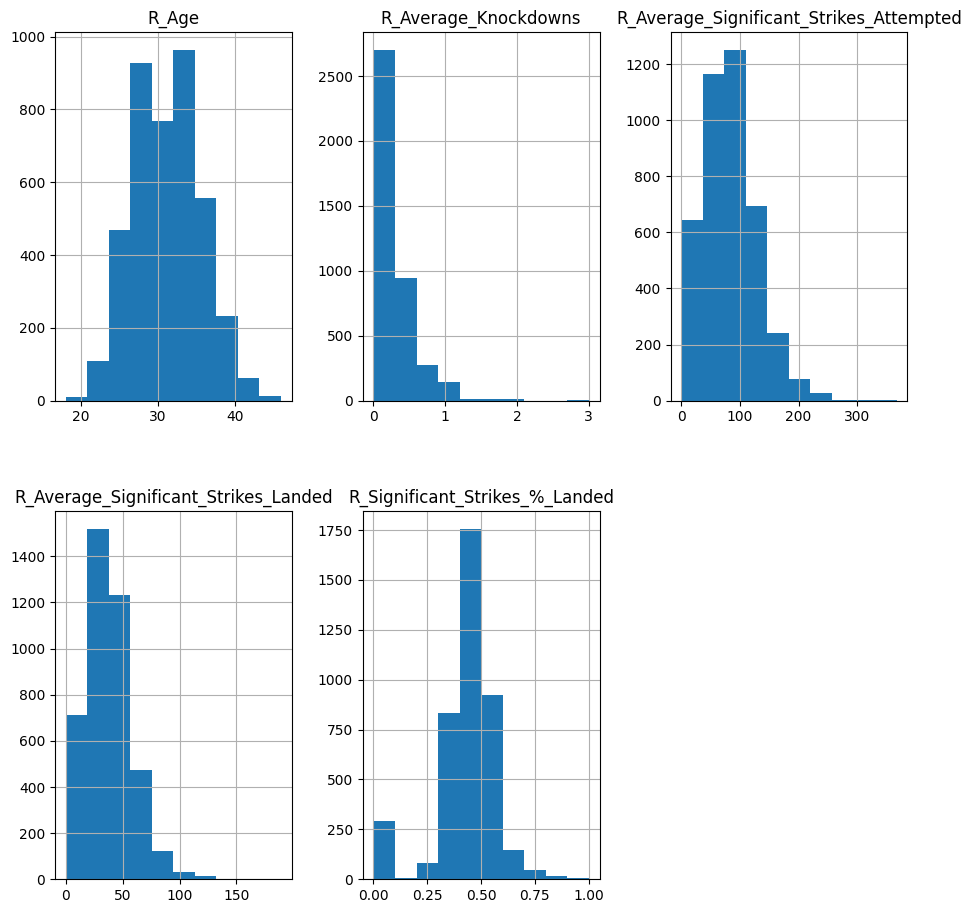

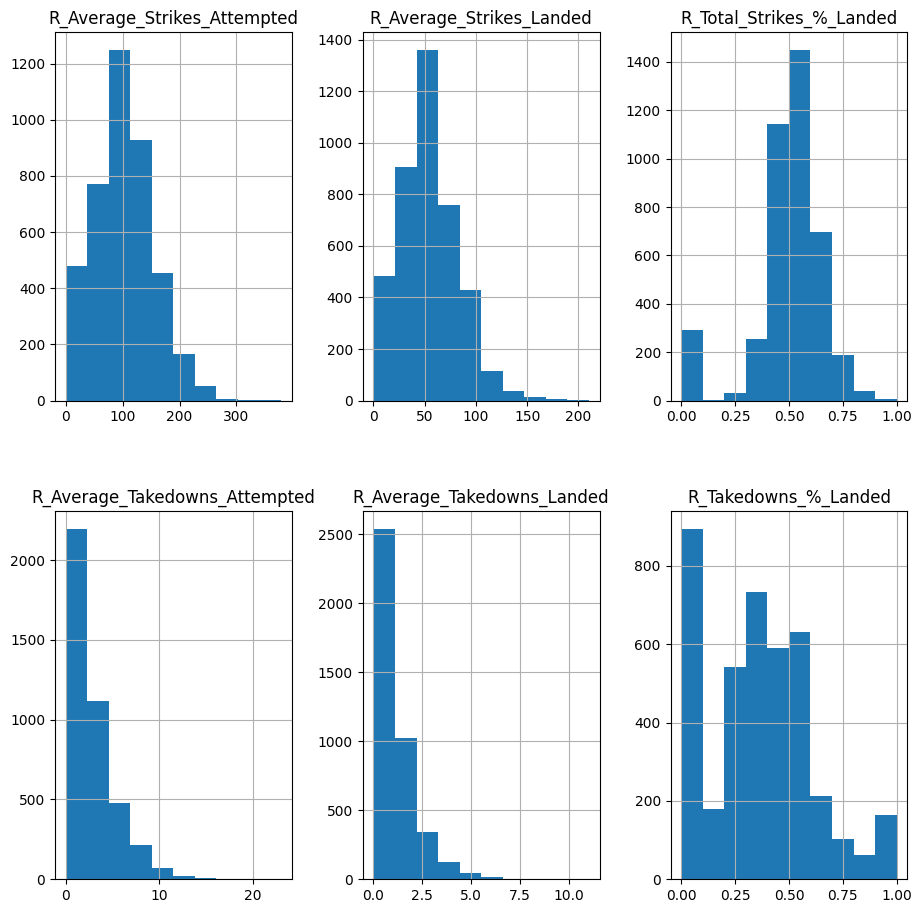

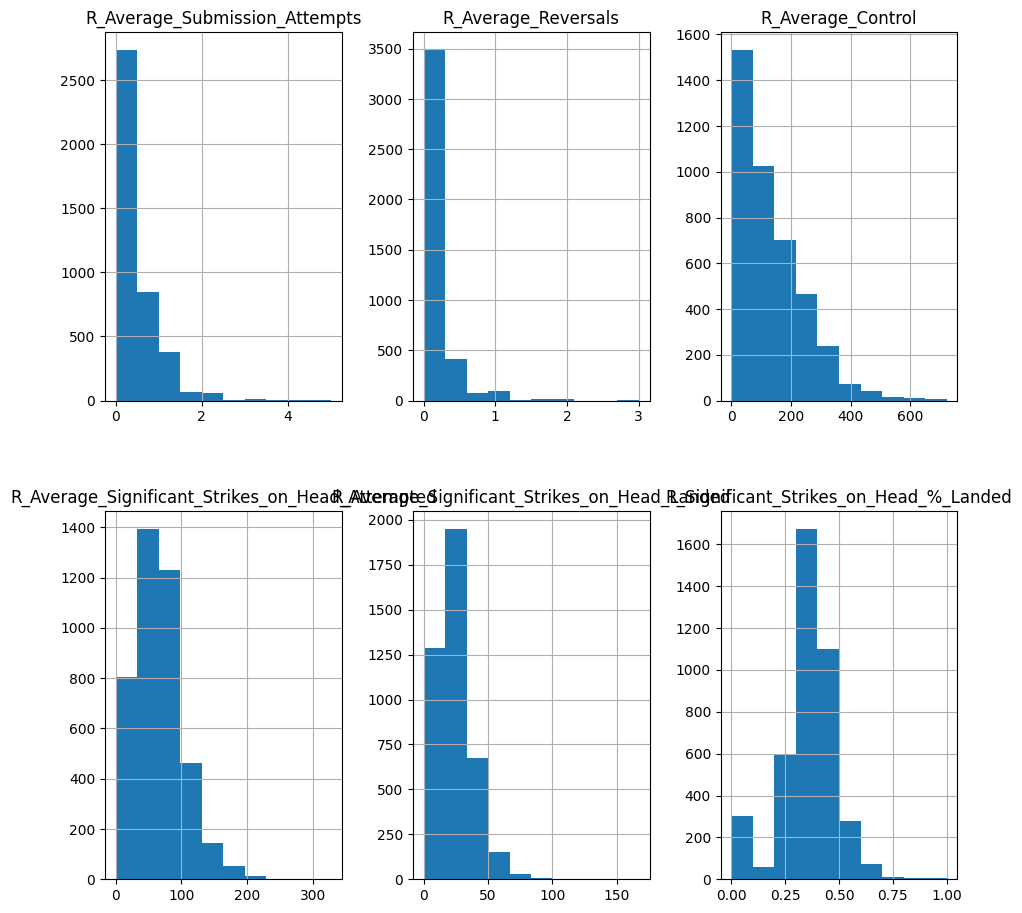

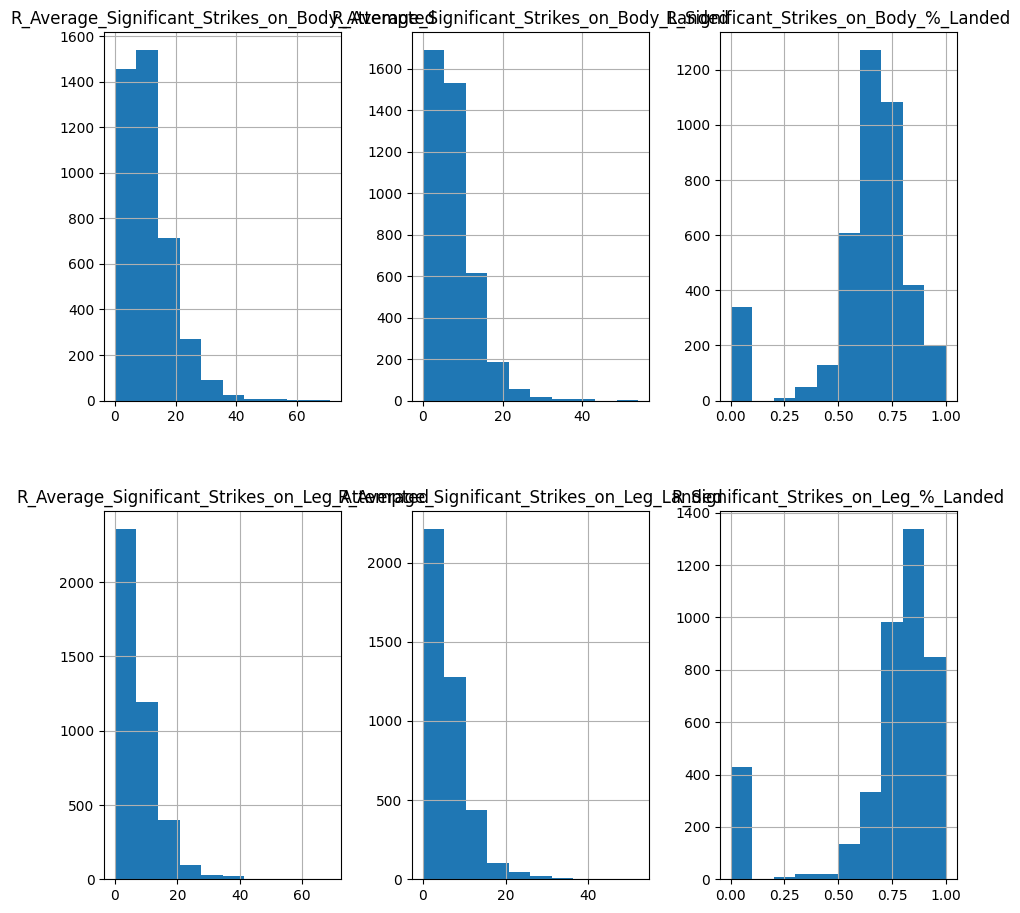

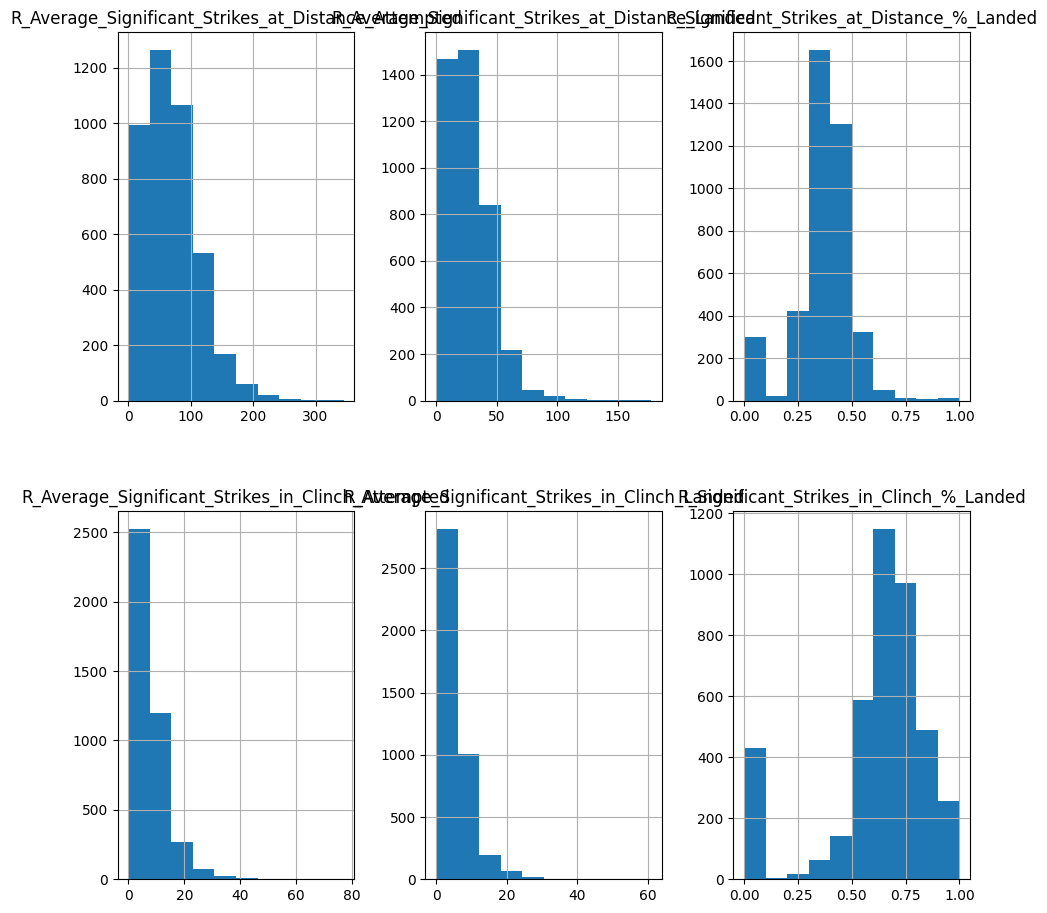

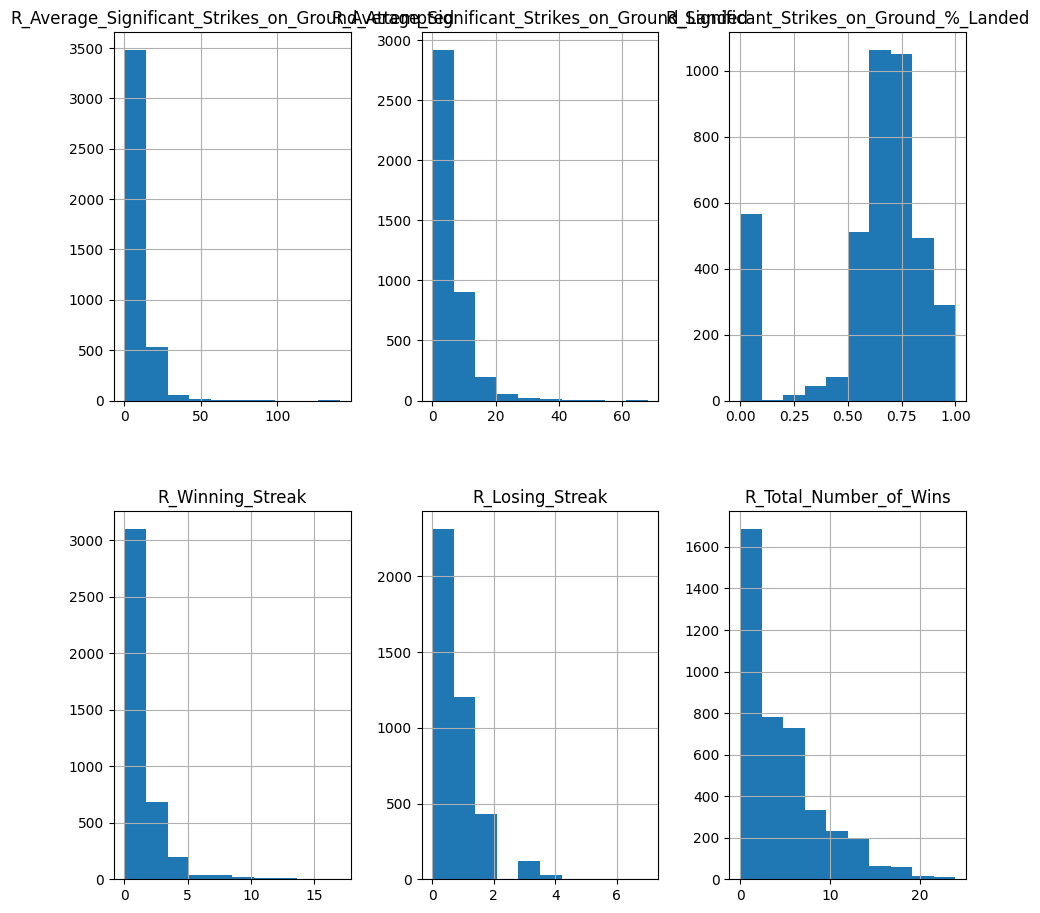

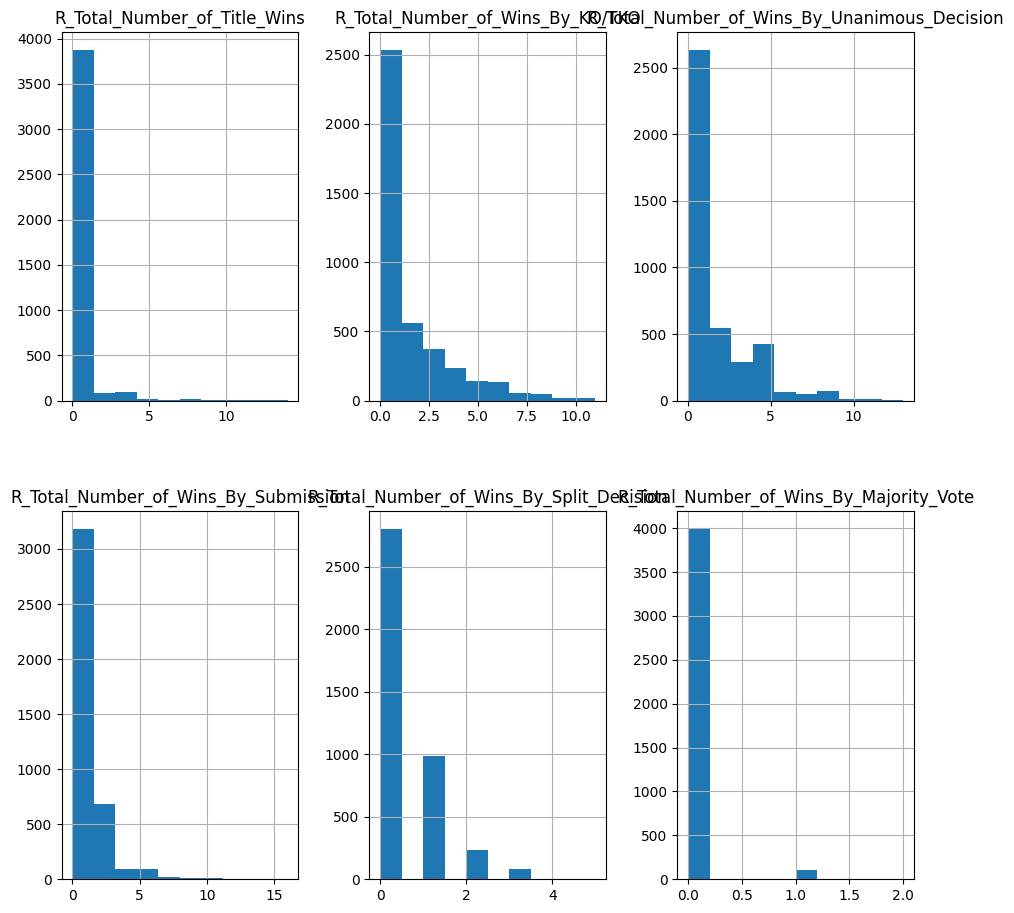

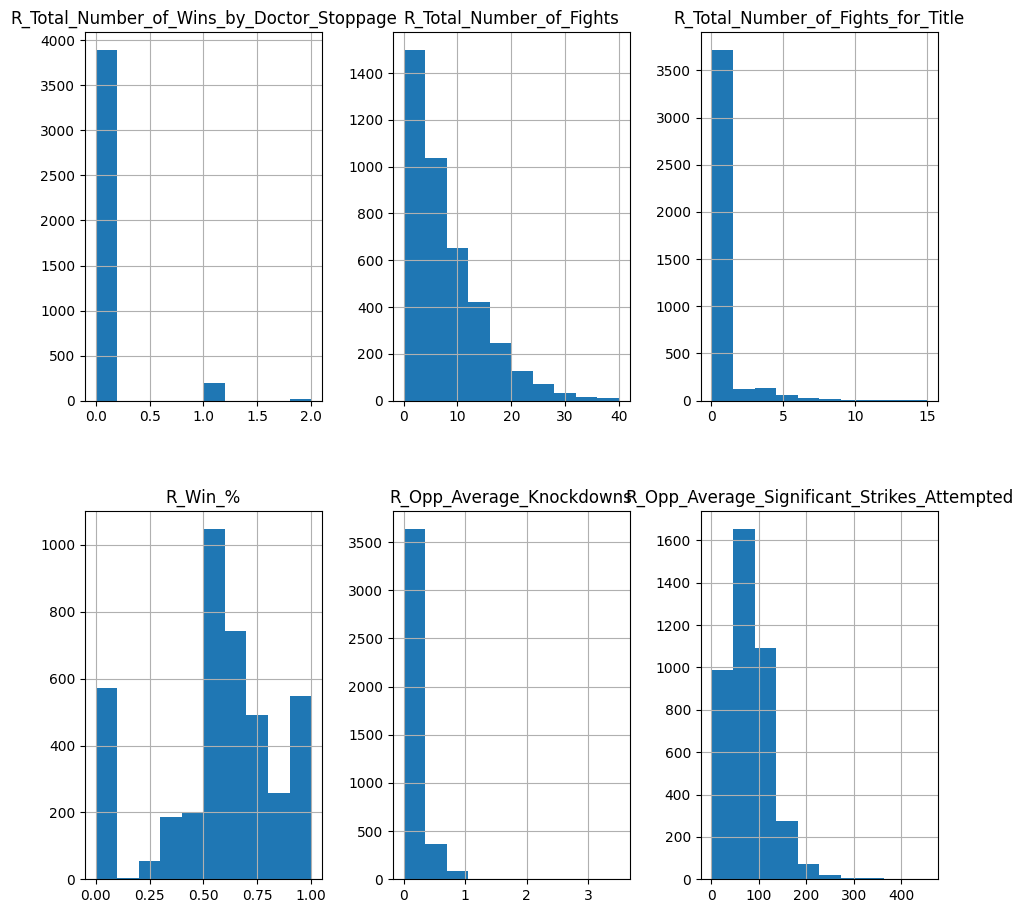

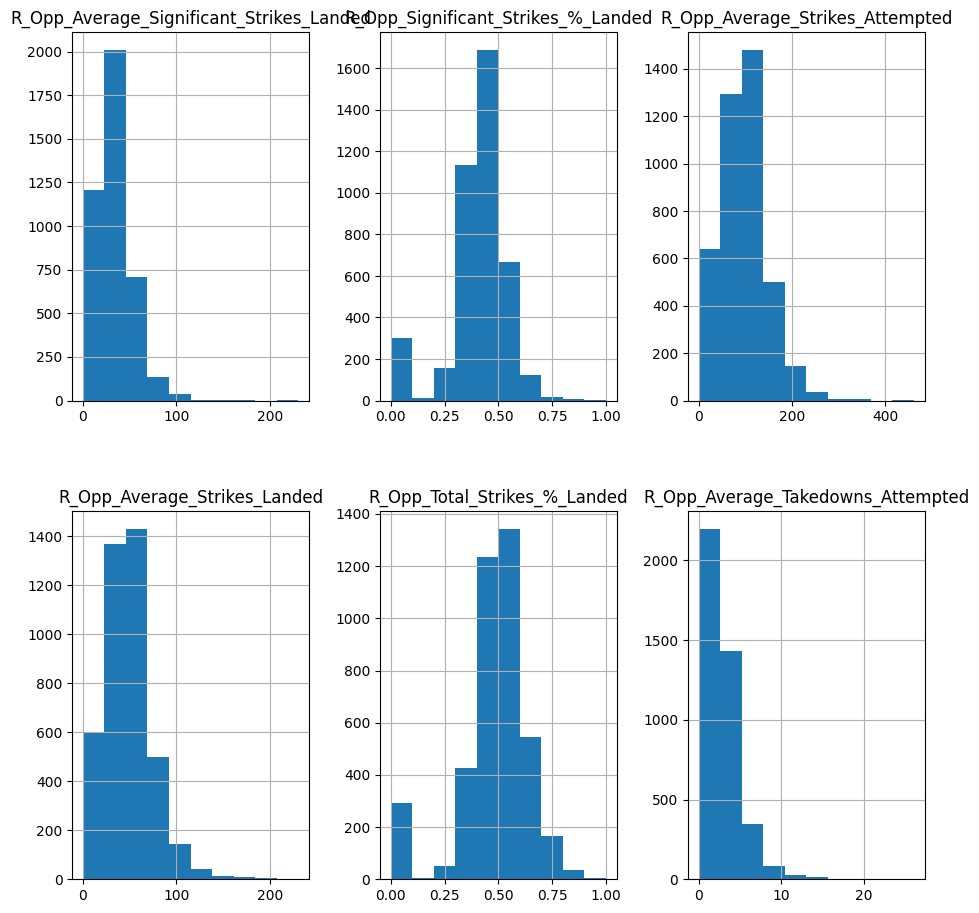

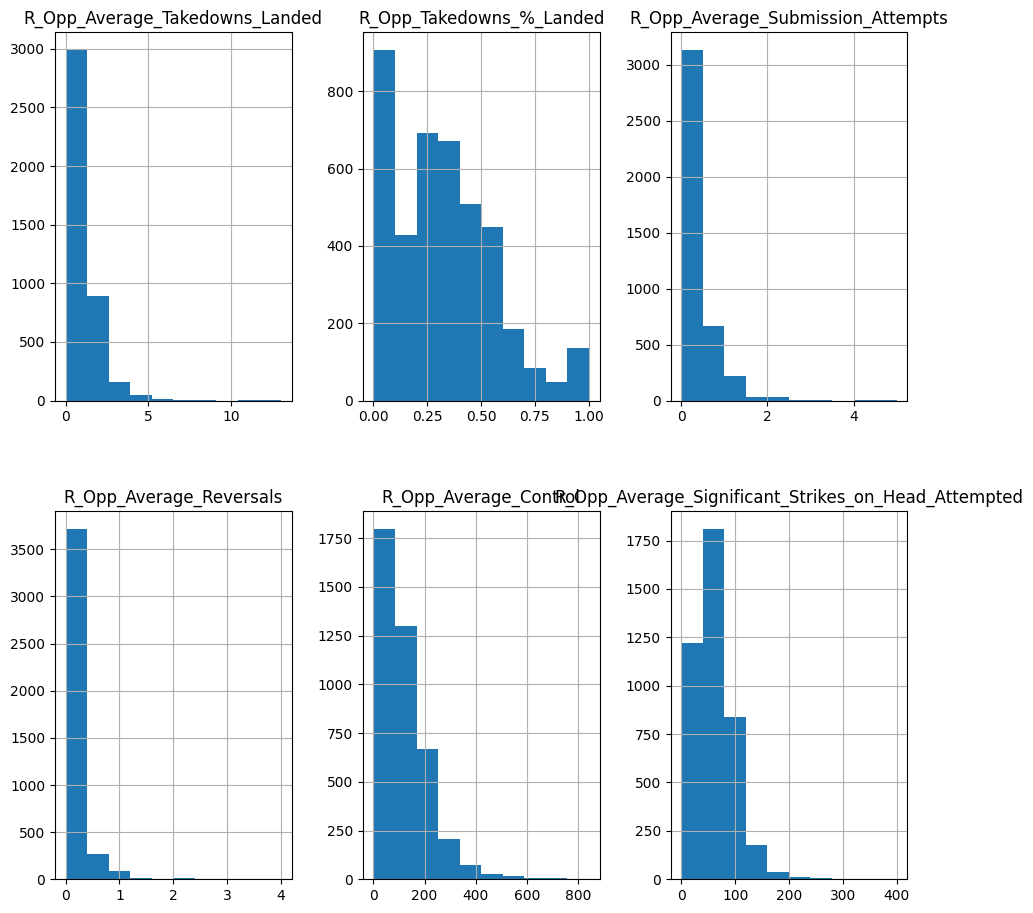

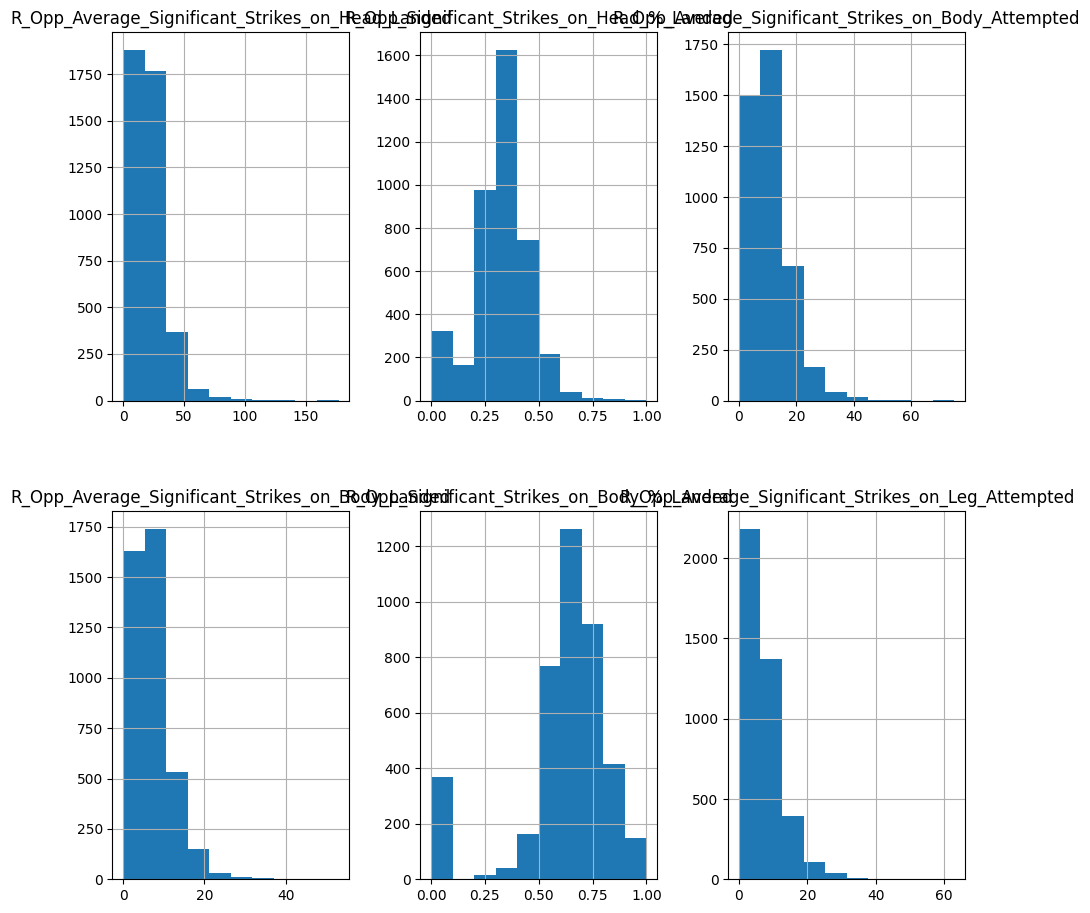

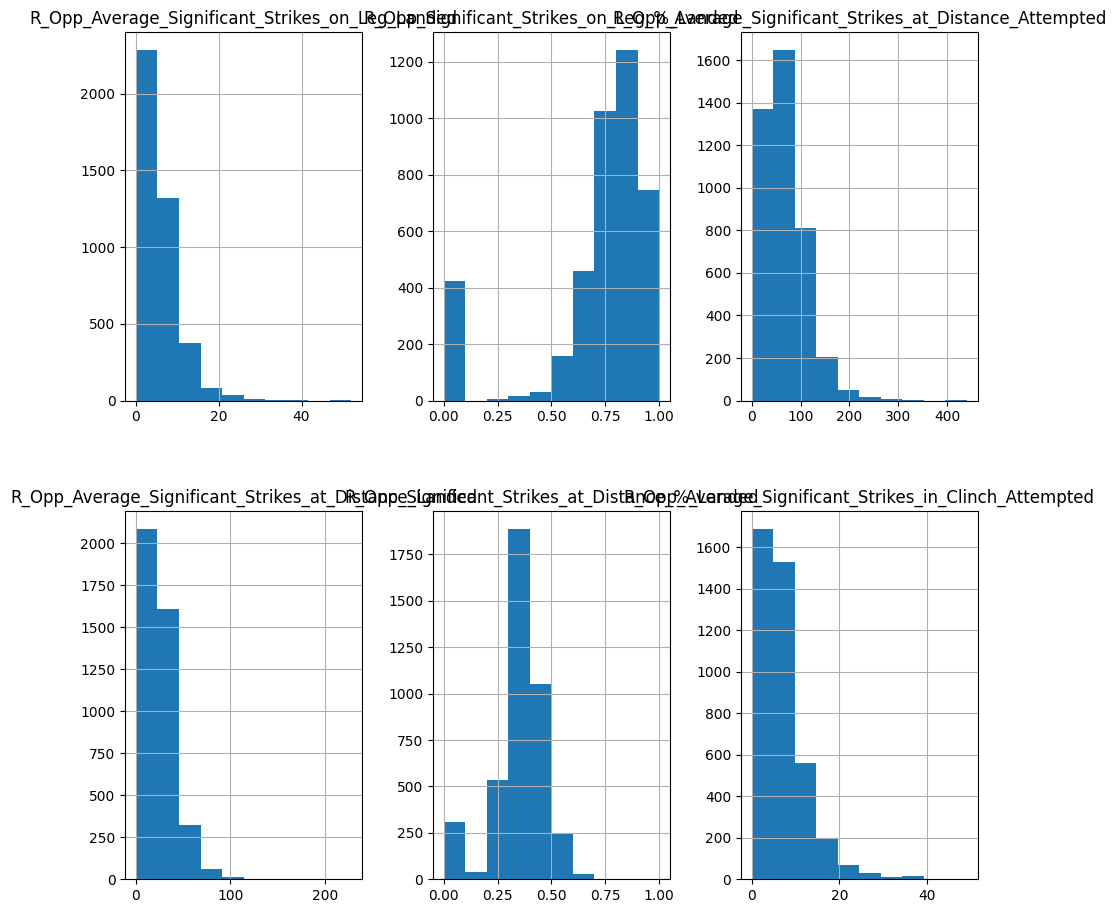

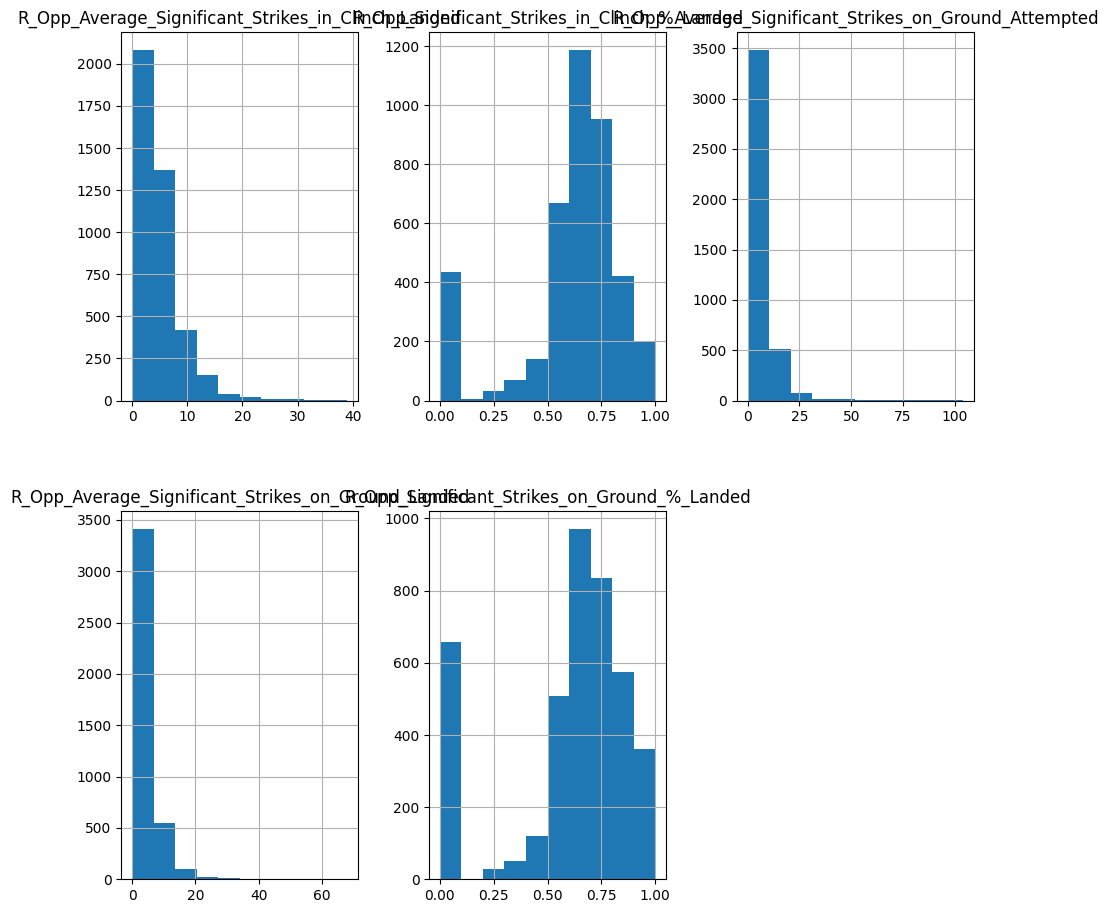

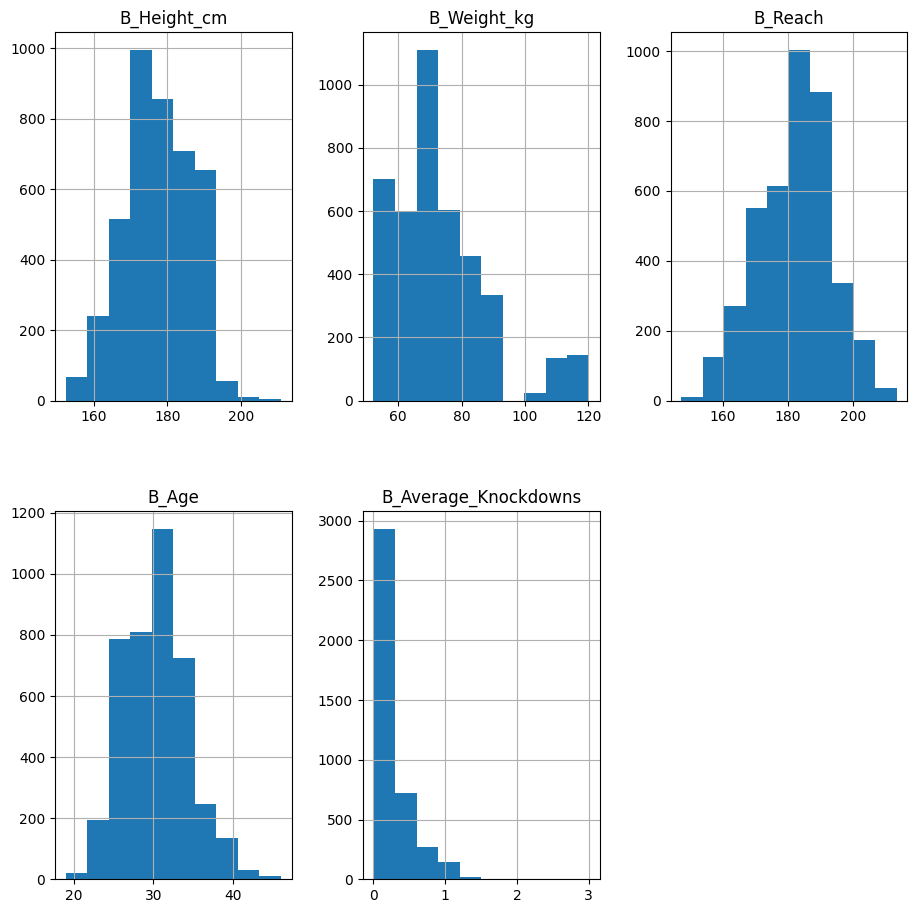

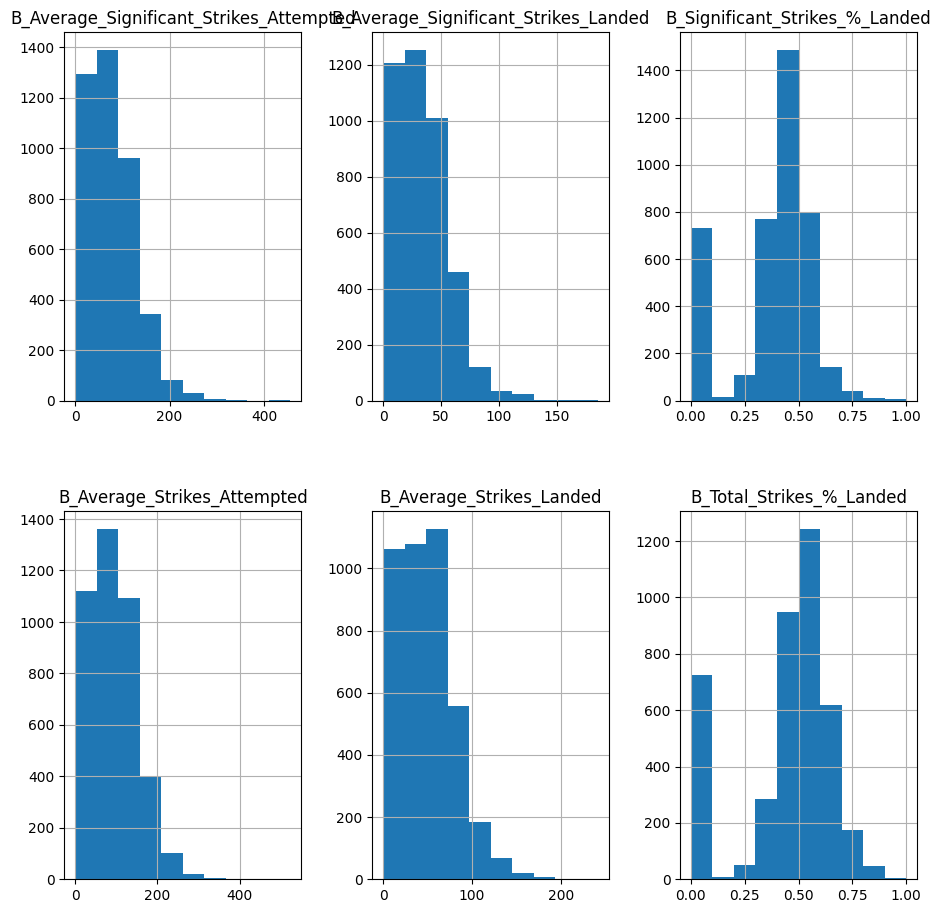

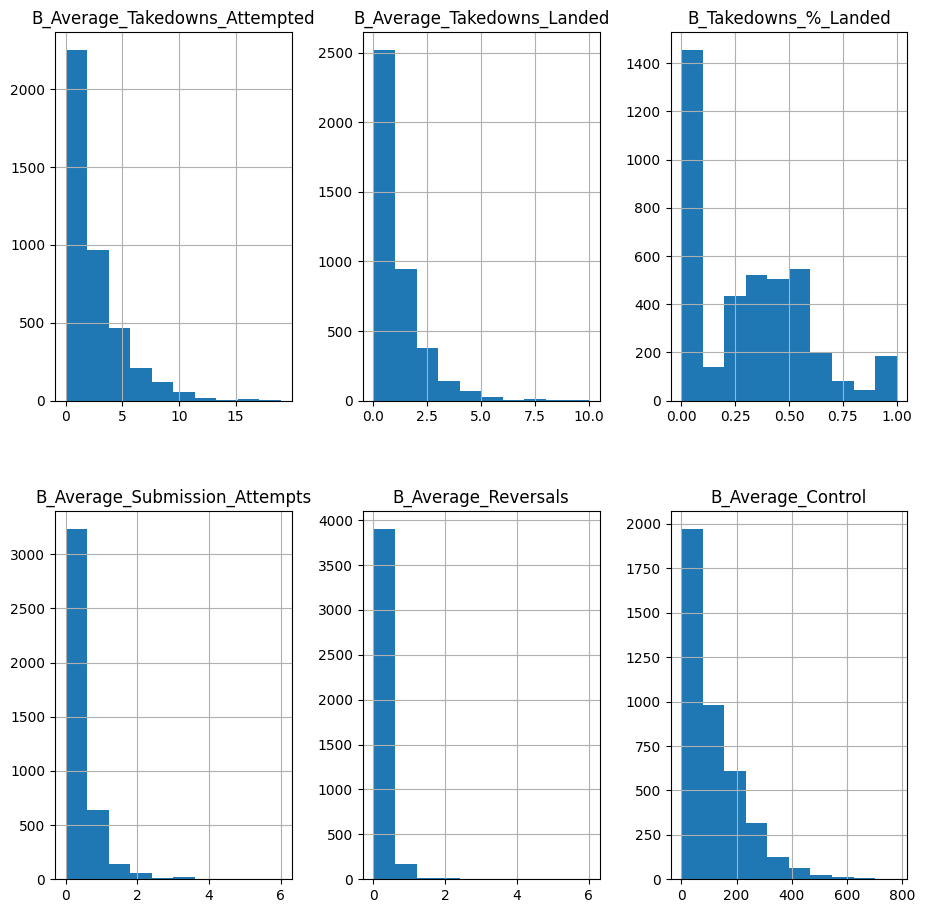

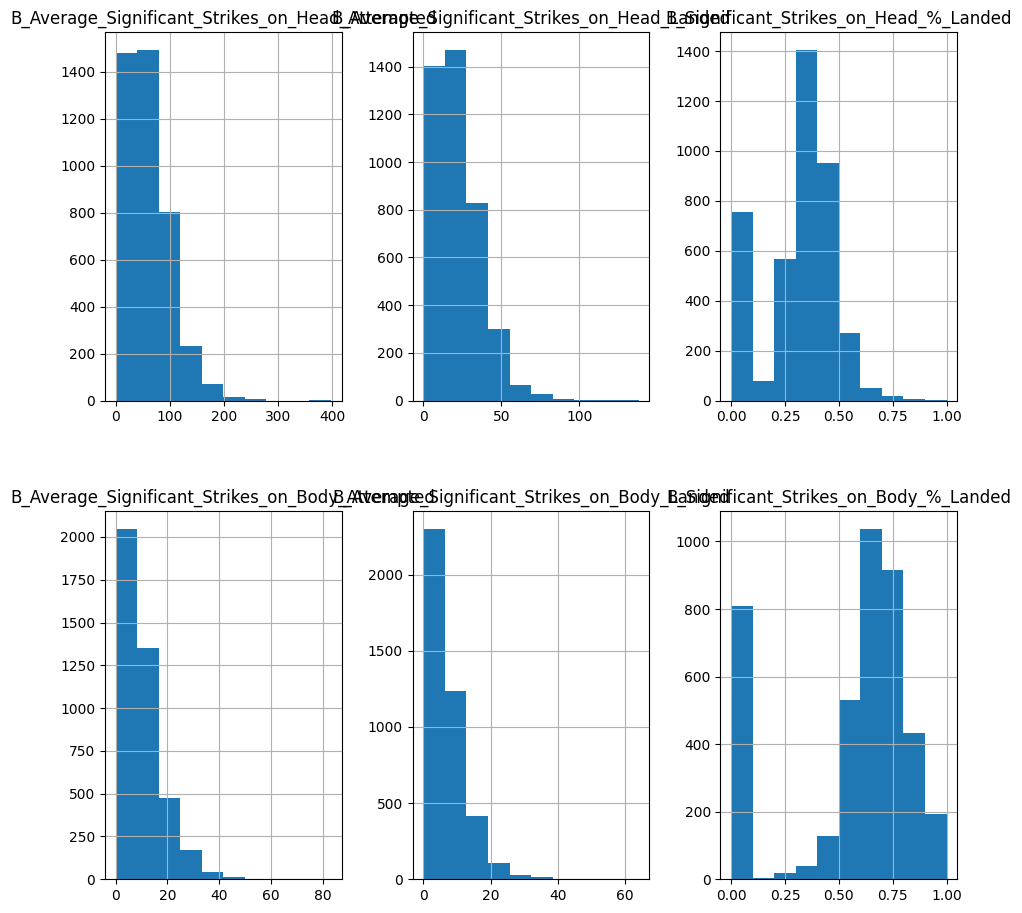

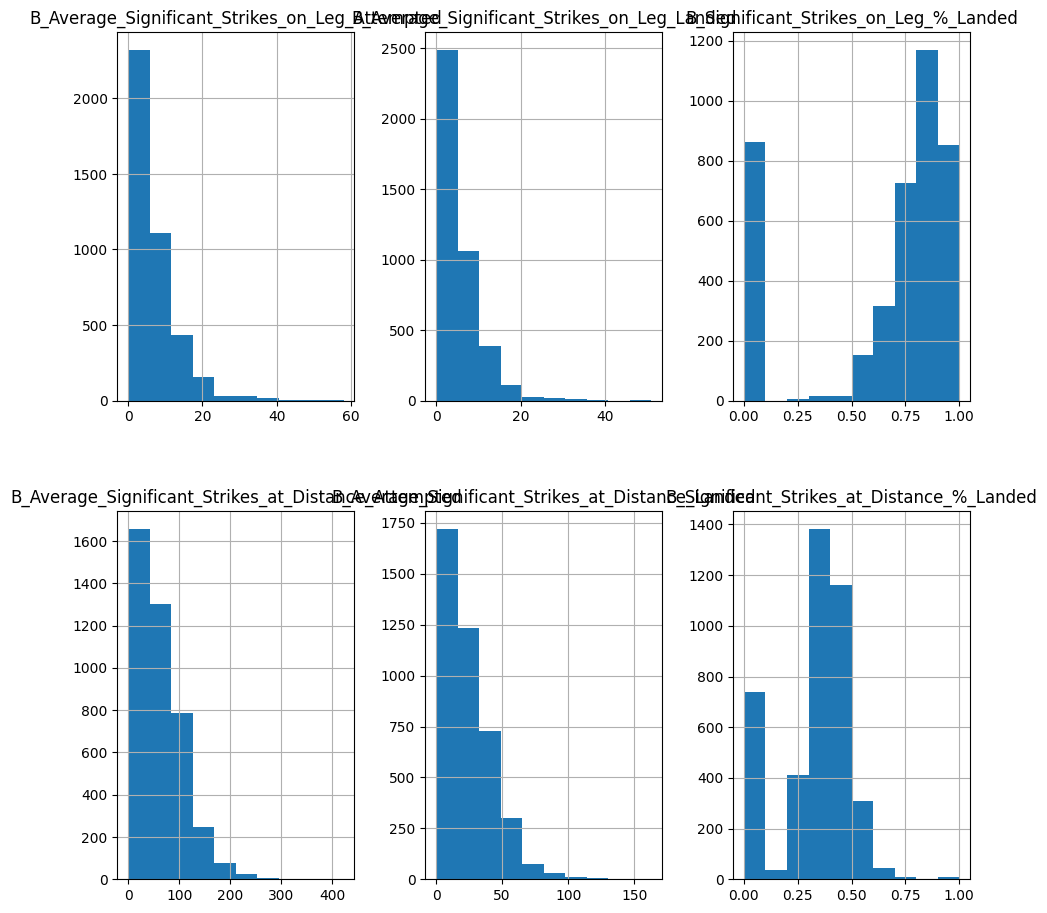

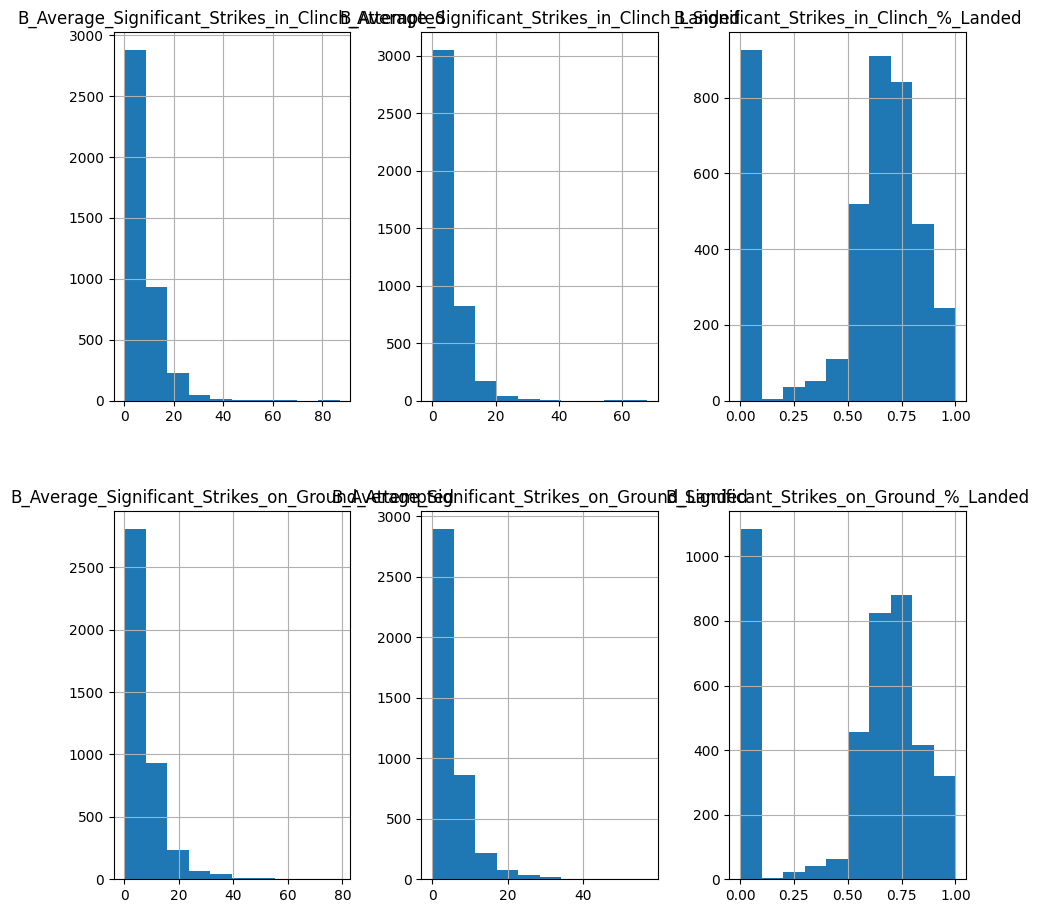

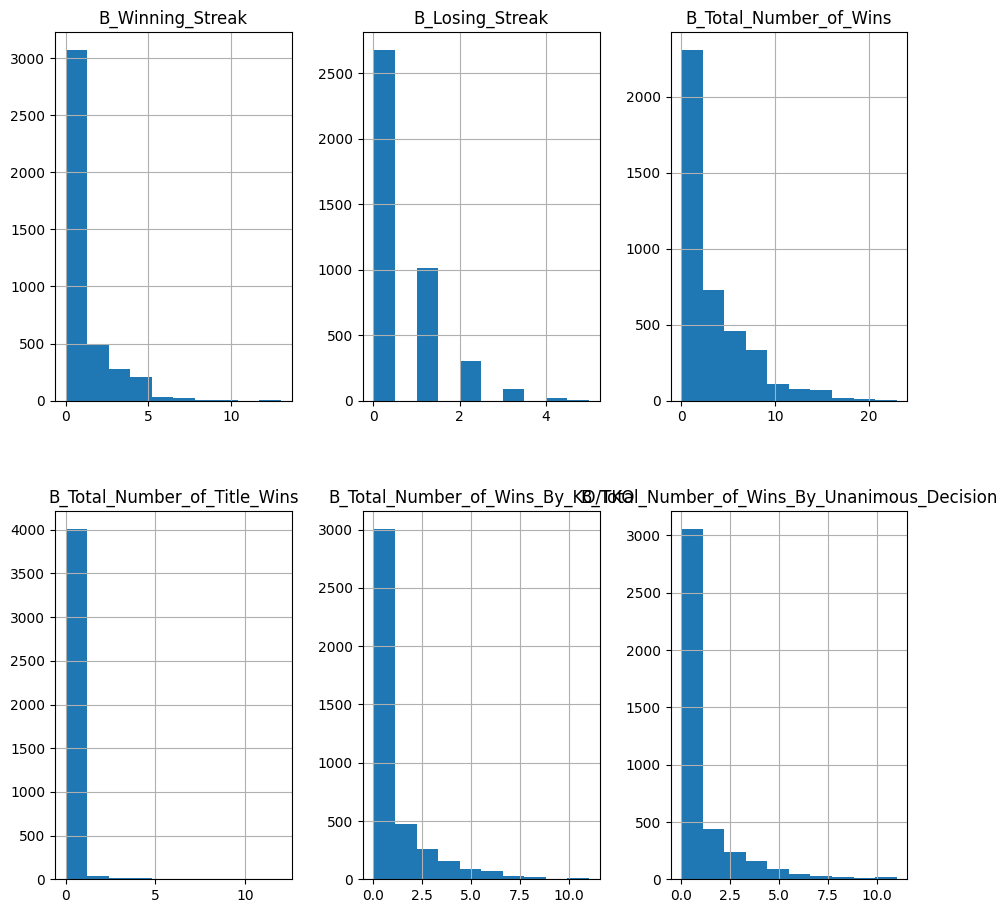

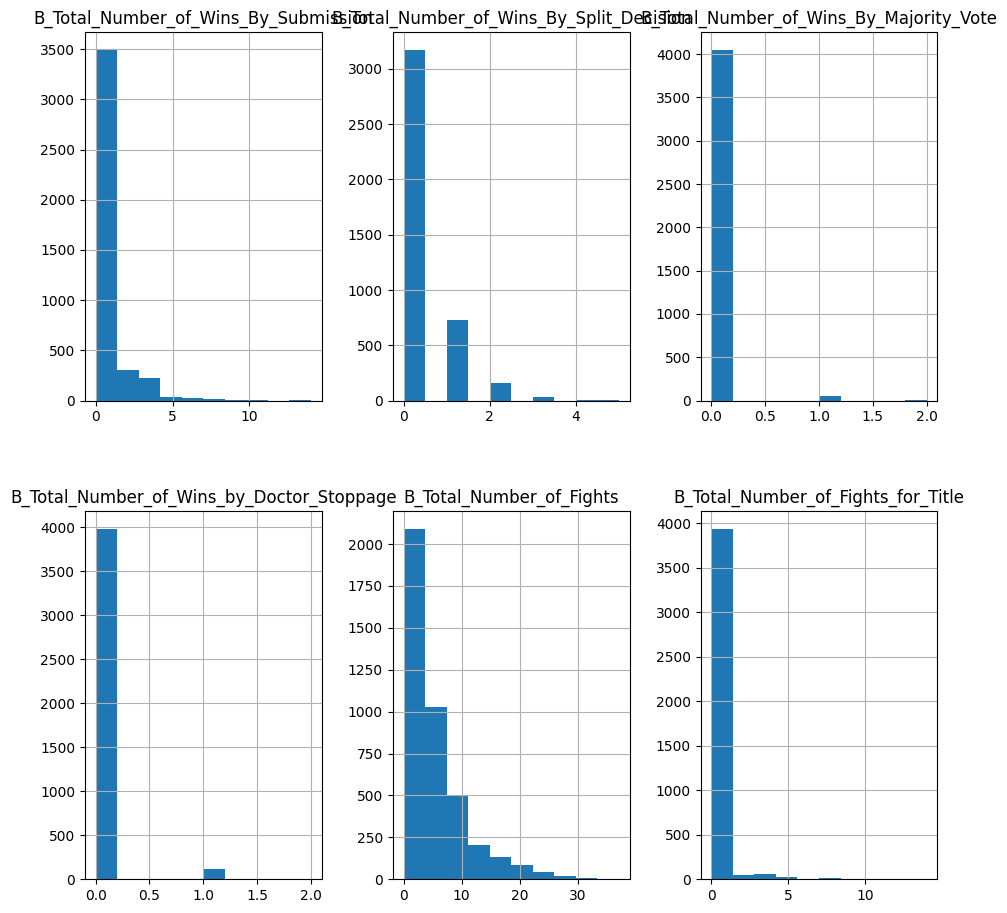

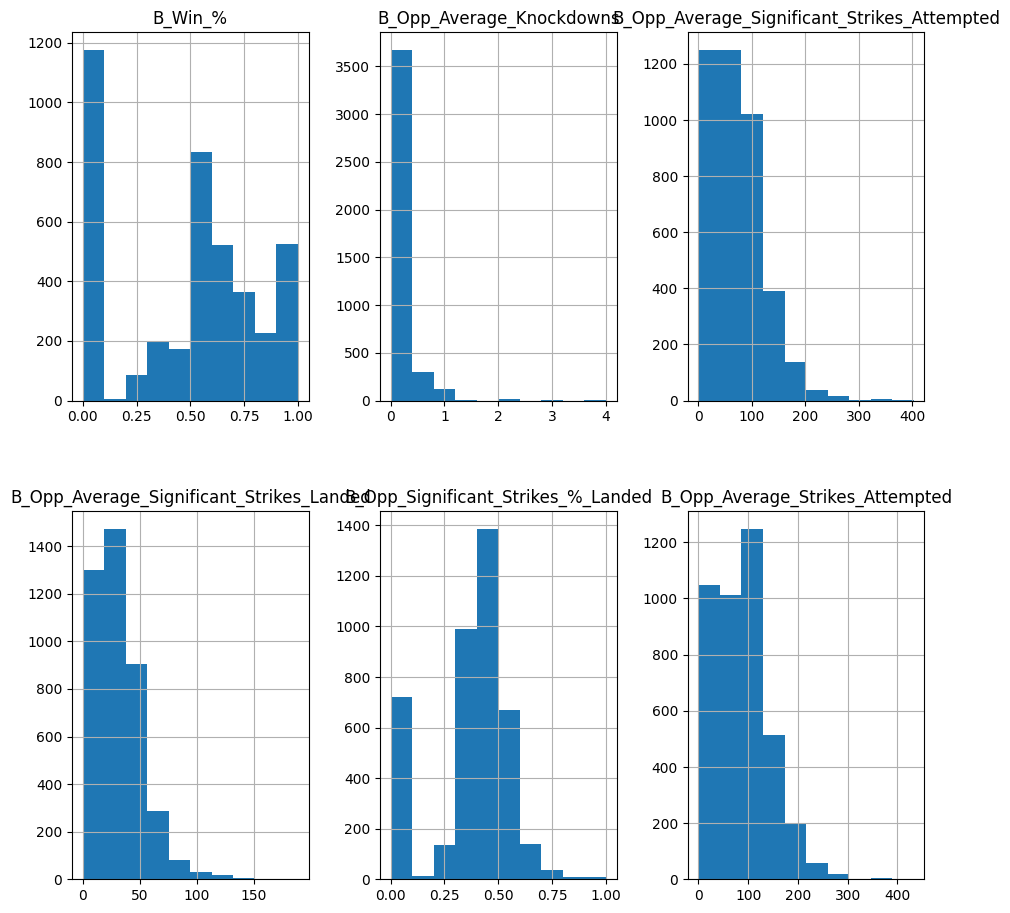

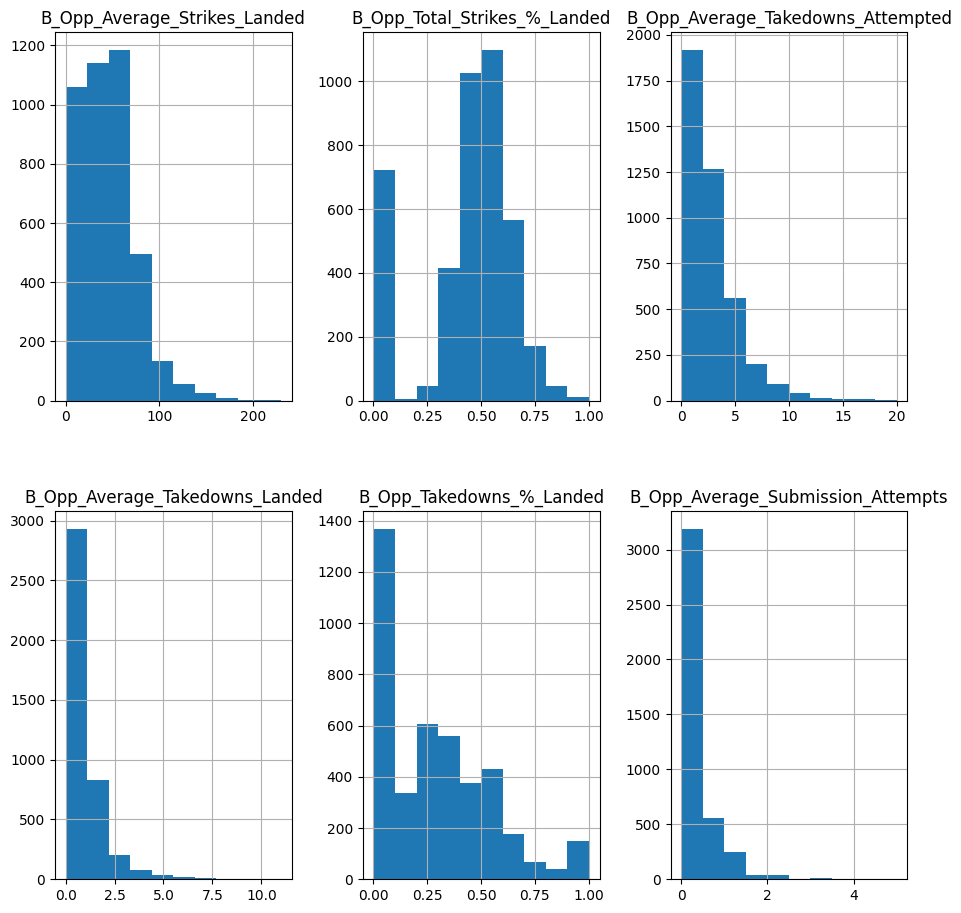

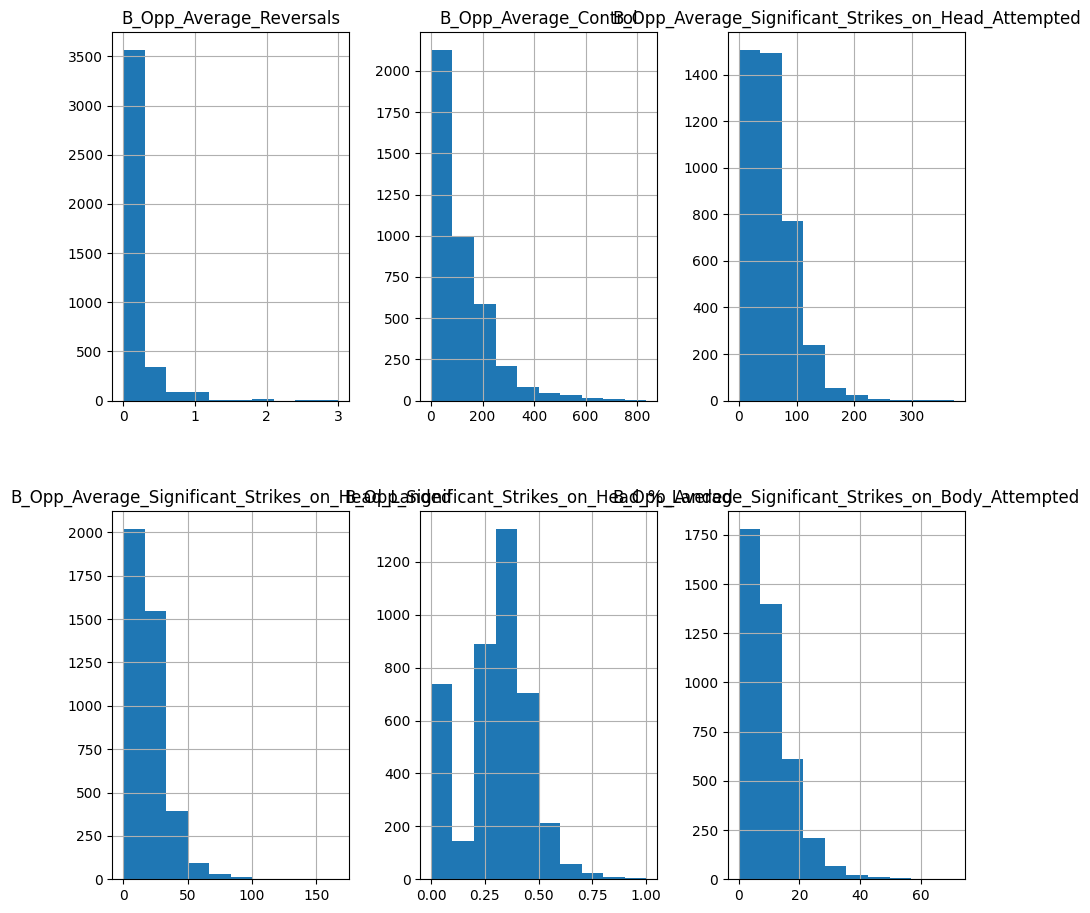

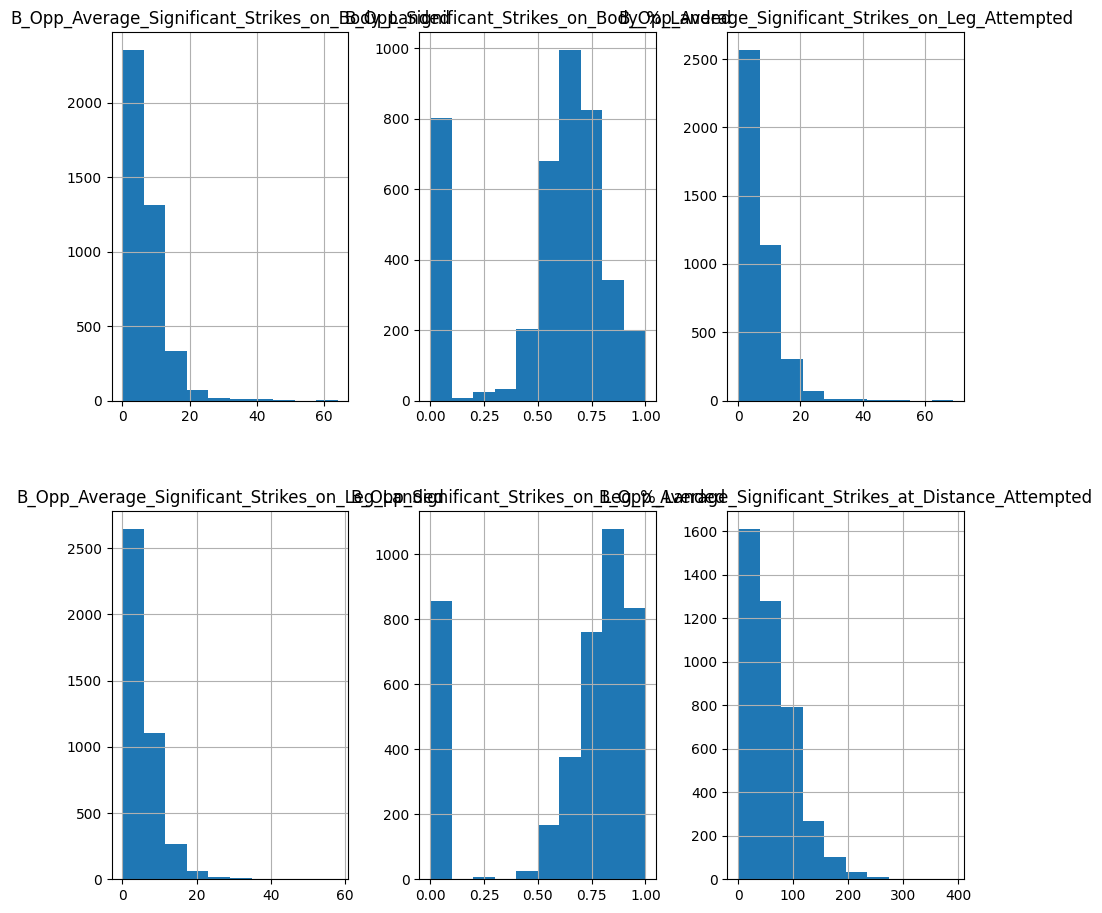

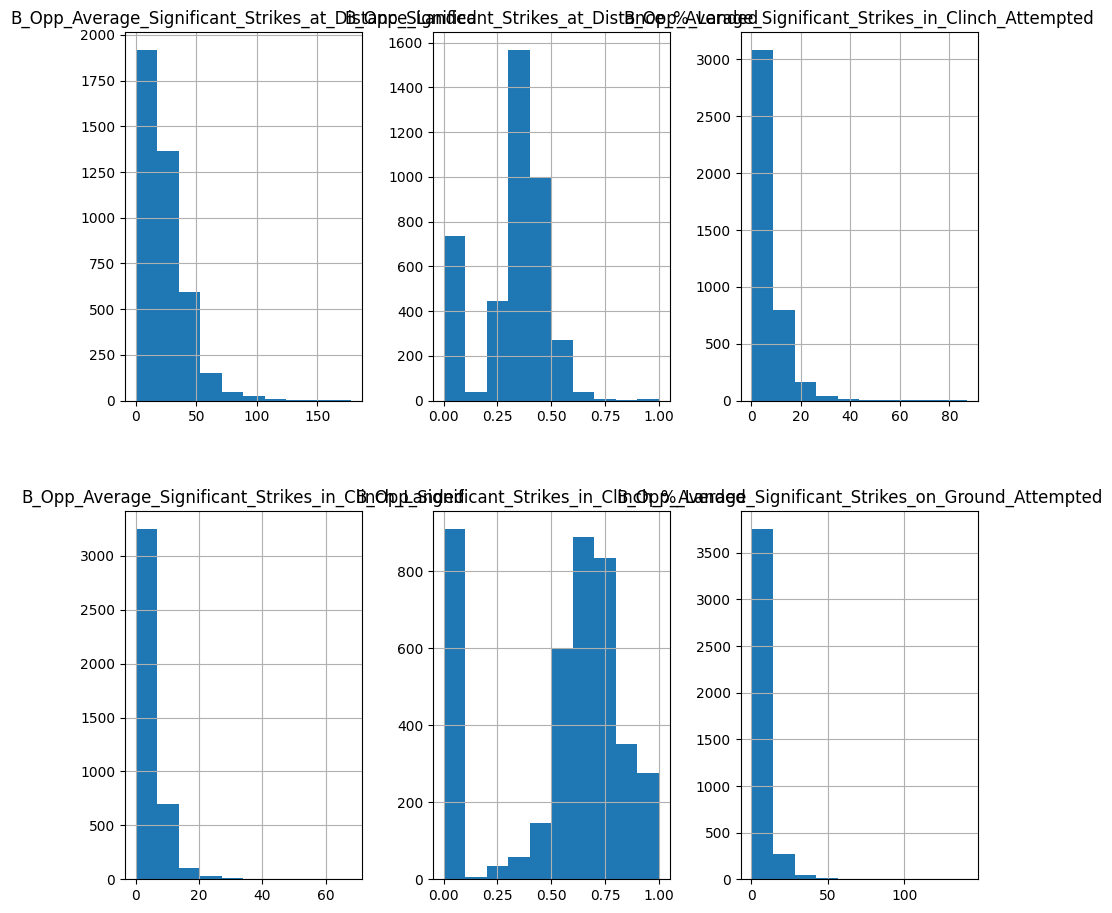

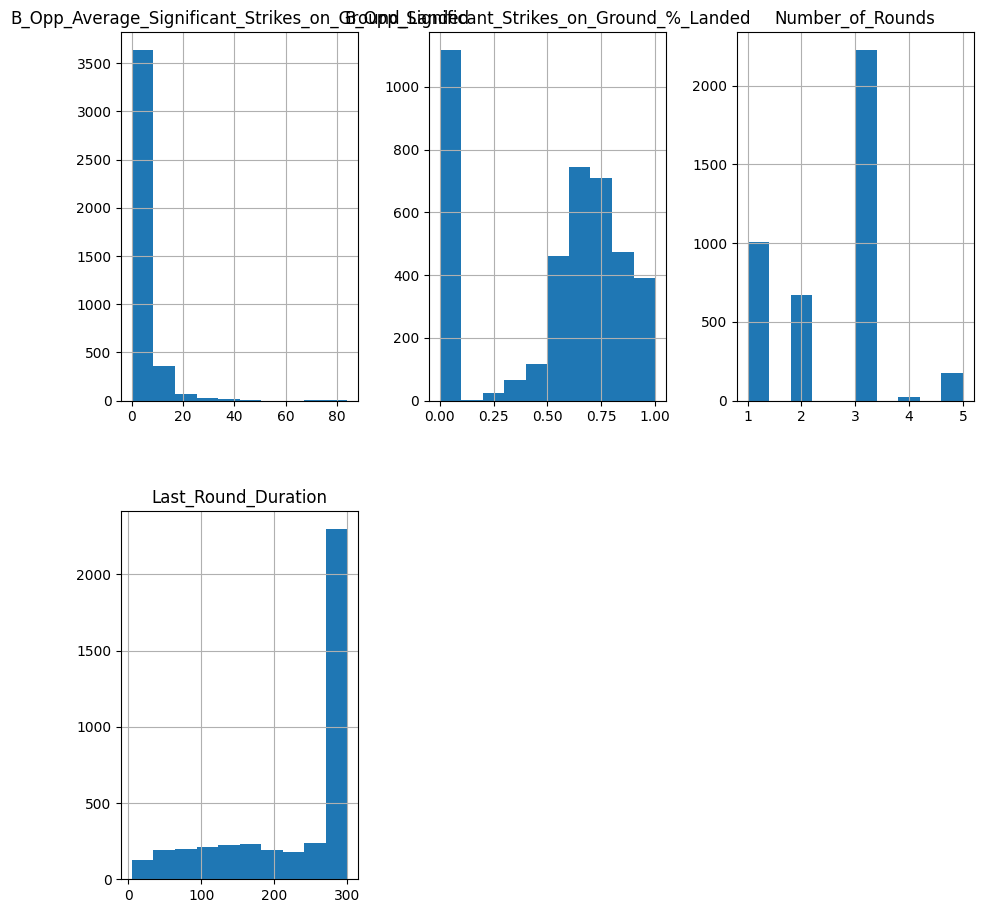

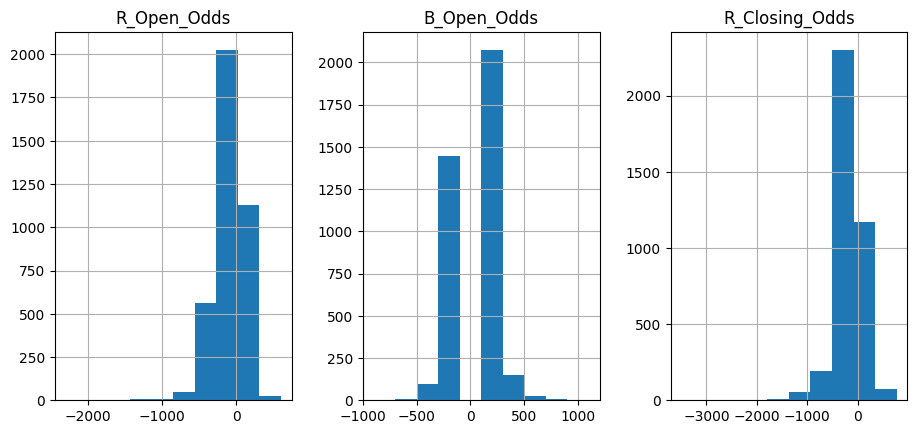

In [35]:
naive_classifier = data.loc[data['Winner'] == 'Red']['Winner'].count() / data['Winner'].count()
print("The naive classifier accuracy is: ", naive_classifier)

feature_dist(data)

It will be quite hard to beat, hence it explains the need to re-run the scraper to obtain more recent data about the fights, since the naive classifier will drop significantly to a little bit over 56%.


We further need to drop some of the columns that will not be of use. I'll also remove closing odds since these will surely improve the model accuracy, but we shouldn't rely on them too much


In [20]:
dropdata = data.drop(['Column1',
                      'Unnamed: 0',
                      'Event_Name',
                      'Event_Location',
                      'B_Name',
                      'R_Name',
                      'Conclusion_Method',
                      'Event_Date',
                      'Last_Round_Duration',
                      'Number_of_Rounds',
                      'Referee',
                      'R_Closing_Odds', # bye bye closing odds...
                      'B_Closing_Odds'], axis=1)

# indices = []
# i = 0
# for _, row in dropdata.iterrows():
#     if row['Time_Format'] == '3 Rnd + OT (5-5-5-5)':
#         indices.append(i)
#         print(i)
#     i += 1
    
# dropdata.iloc[indices,:].head()


Next, let's find numerical and categorical columns in our dataset. 

In [36]:
objecttypes_cat = list(dropdata.select_dtypes(include=['O']).columns)
objecttypes_num = list(dropdata.select_dtypes(include=['int64', 'float64']).columns)

# we don't want to one-hot encode 'Winner' since it's not really required
# and the pipeline braeks if we do (it'll be looking for this var in 
# X_train&X_test but it's obviously not there)
objecttypes_cat = [x for x in objecttypes_cat if x != 'Winner']

# for col in objecttypes:
#     dropdata[col] = dropdata[col].astype('category')
    

## Data correlation

Since we are givem a considerate number of features, instead of presenting all possible correlations, we'll stick to N most significant ones.


In [ ]:
# Basic Correlation Matrix
# corrmat = data.corr()
# f, ax = plt.subplots(figsize=(12, 9))
# seaborn.heatmap(corrmat, vmax=.8, square=True);

In [ ]:
# # Subset Correlation Matrix
# k = 10 #number of variables for heatmap
# corrmat = dropdata.corr()
# cols = corrmat.nlargest(k, 'Winner')['Winner'].index
# cm = np.corrcoef(dropdata[cols].values.T)
# seaborn.set(font_scale=1.25)
# hm = seaborn.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
# plt.show()

# Candidate models

We've chosen the following candidate models that we will further try to get the best performance from. In the end, we will present a comparison of each model.

#### - Perceptron
#### - Random Forests
#### - Decision Trees Classifier
#### - SGD Classifier
#### - Linear SVC
#### - Gaussian Naive Bayes
#### - KNN


In [37]:
tuned_models = dict()

### Standardizing the data (based on X_train):

c:\users\mewash\desktop\datascienceprojectpython\myenv\lib\site-packages\pandas\plotting\_matplotlib\tools.py:227: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(**fig_kw)


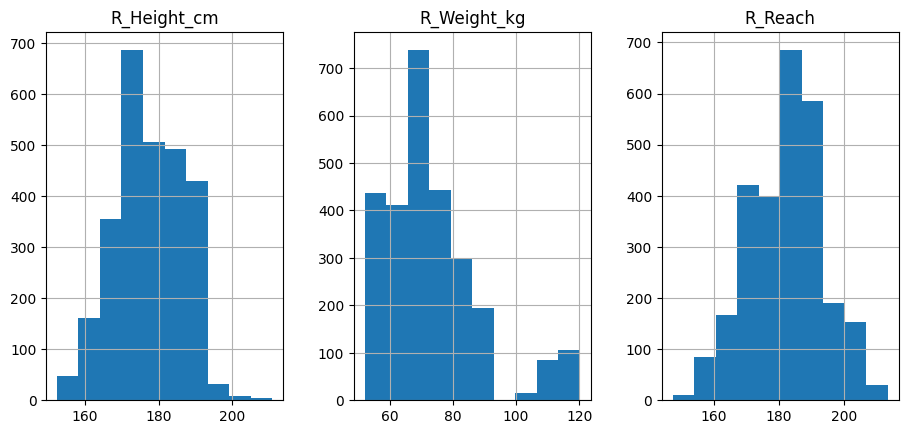

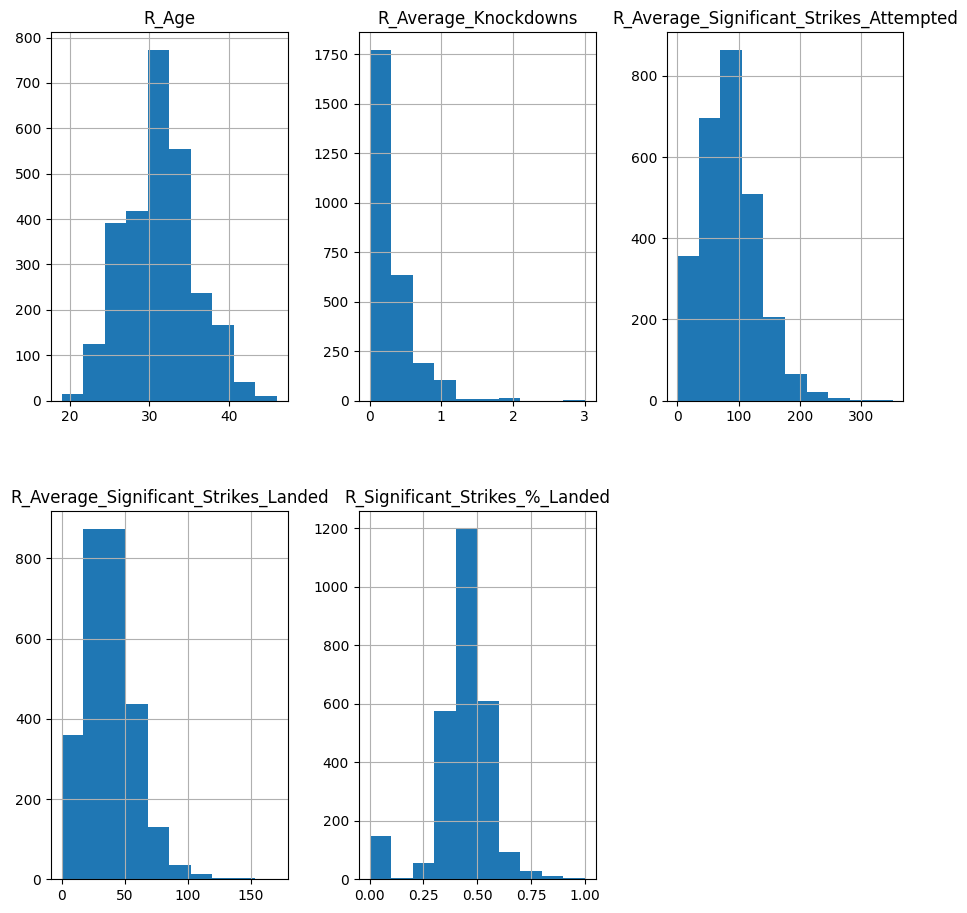

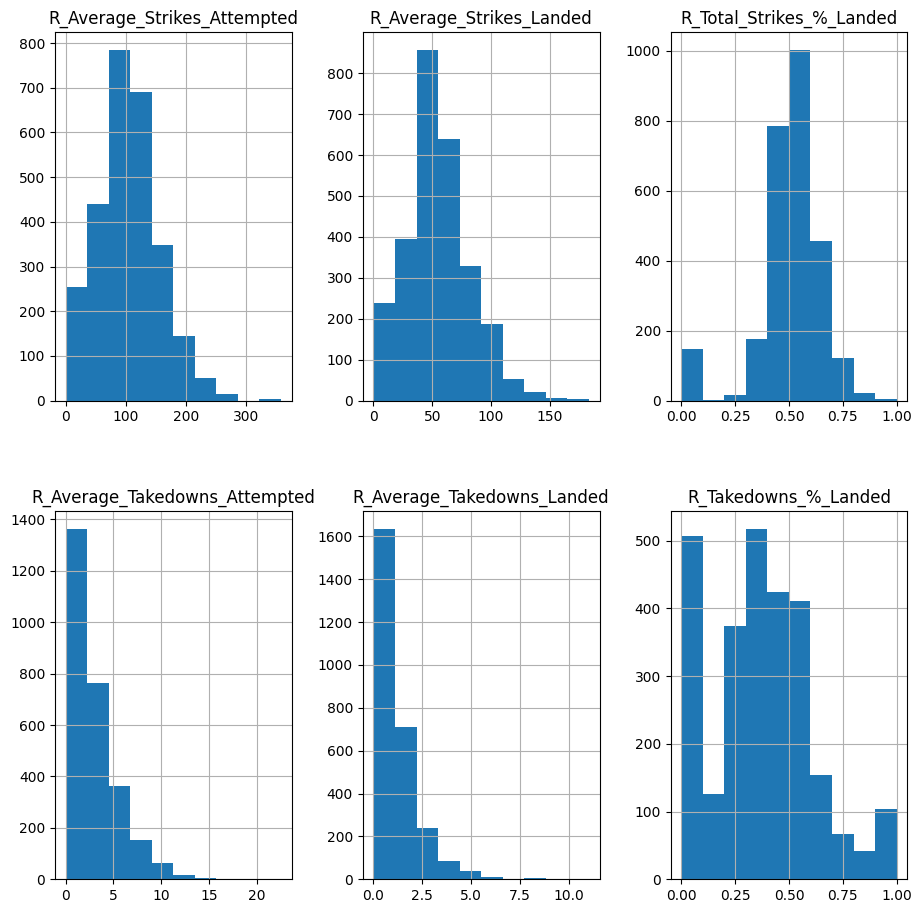

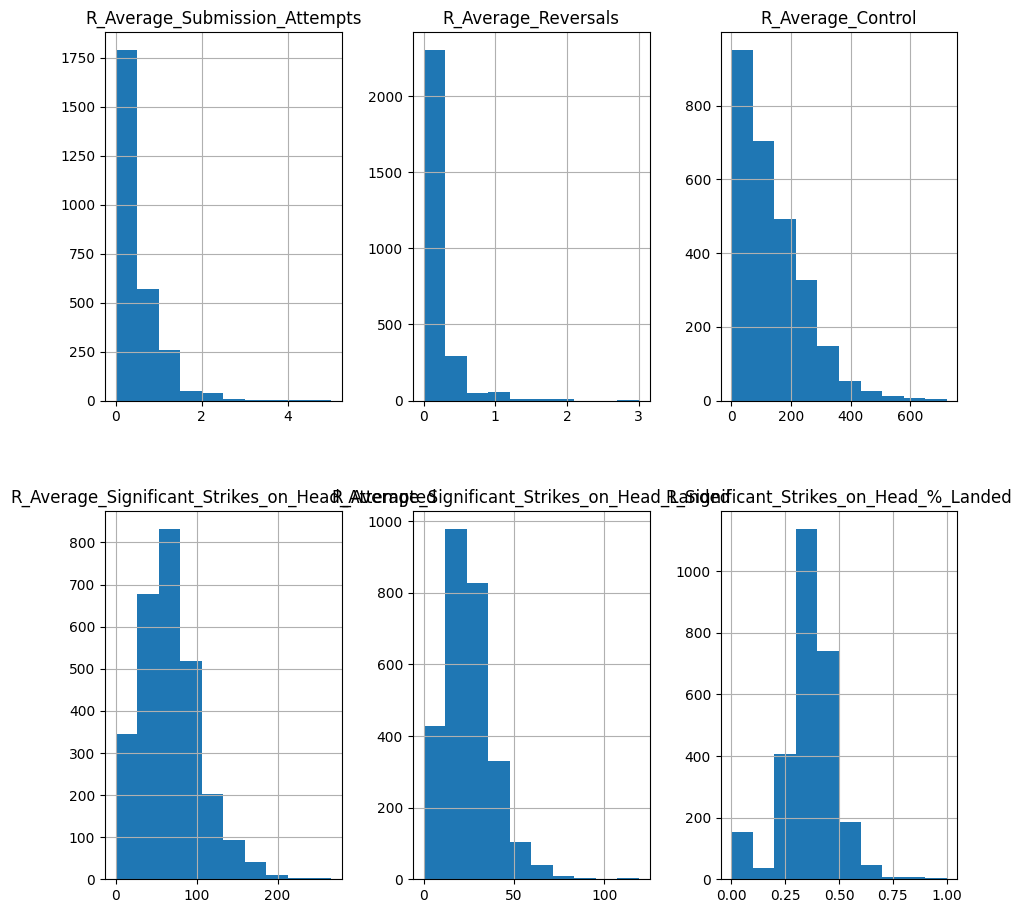

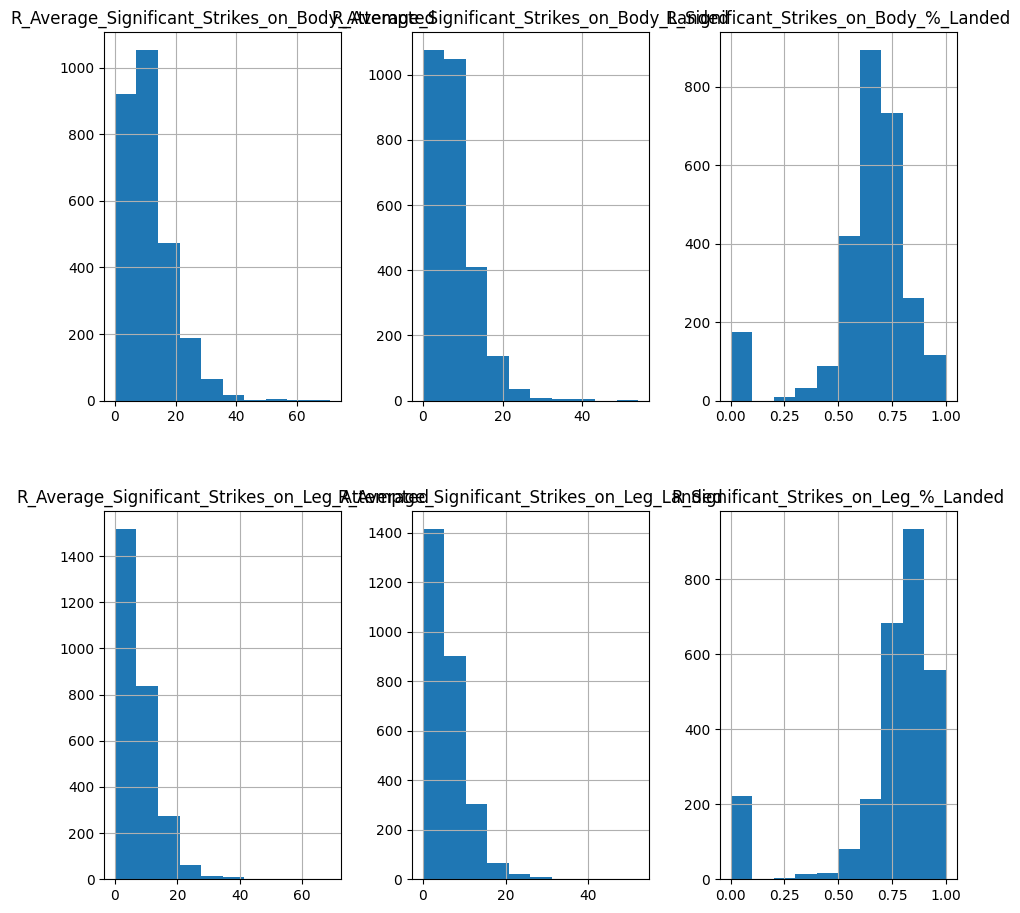

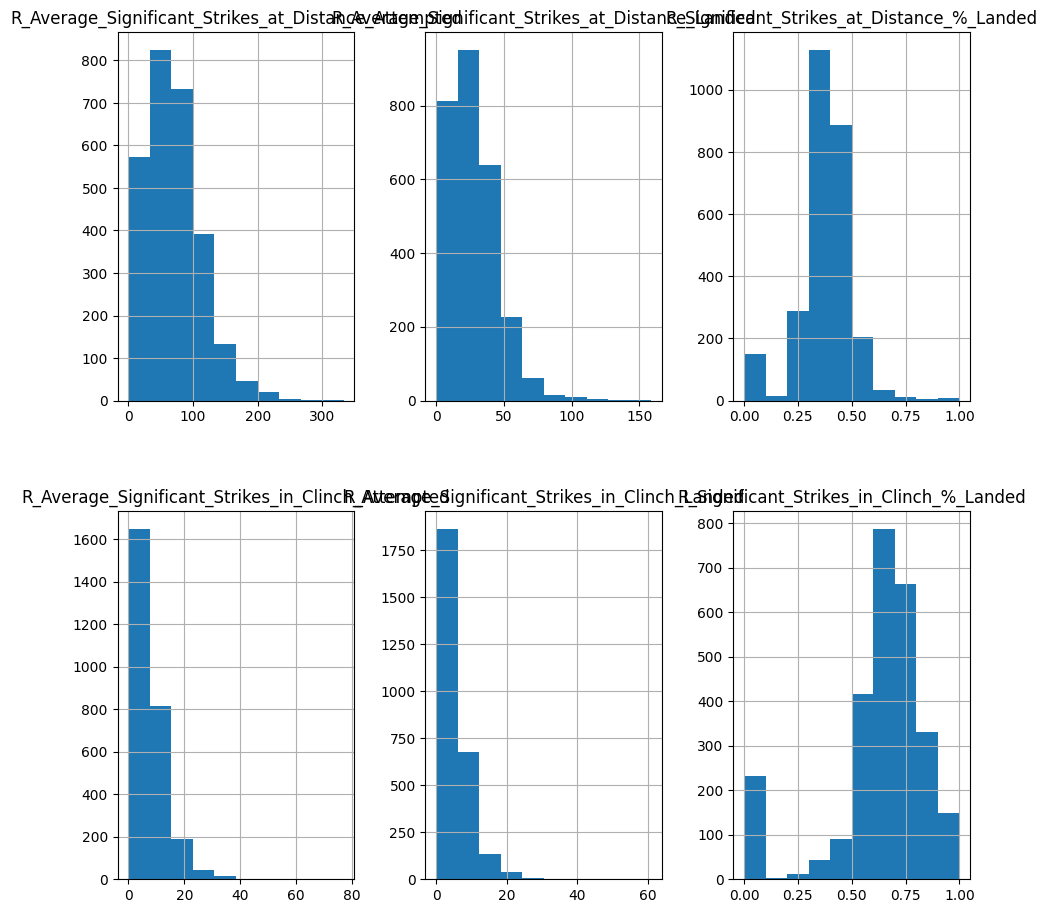

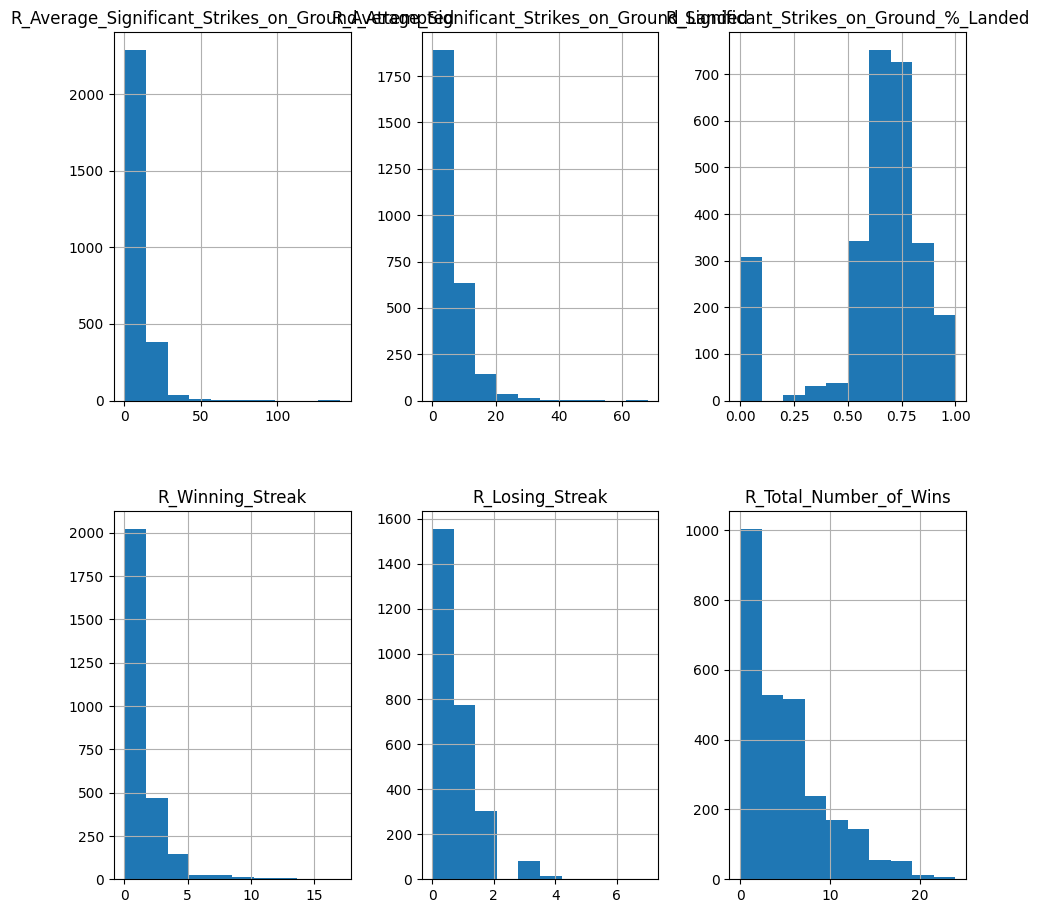

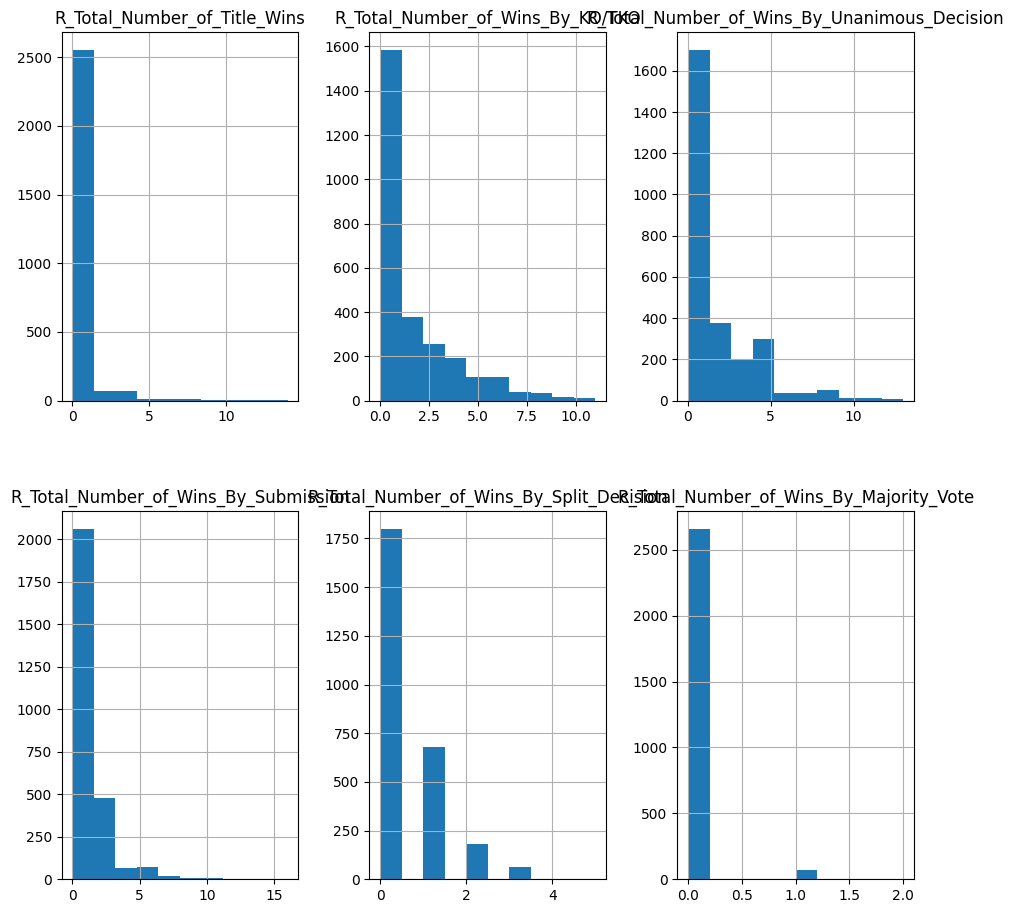

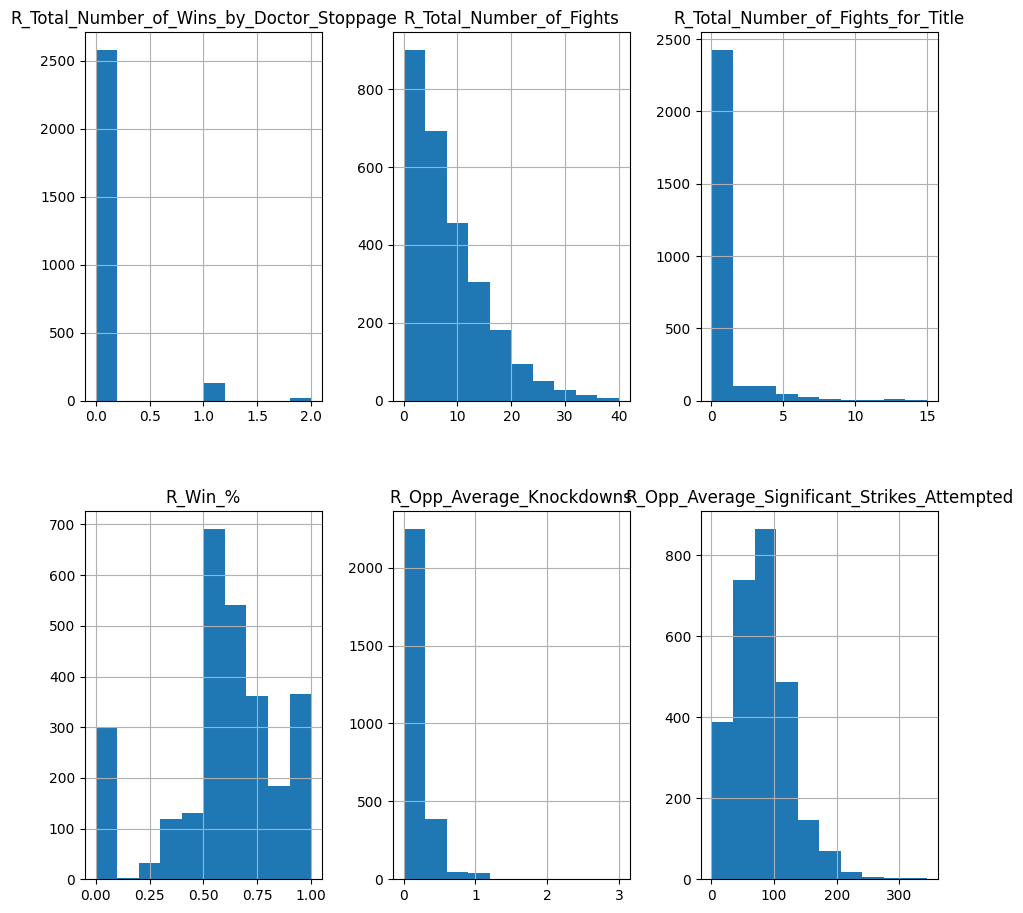

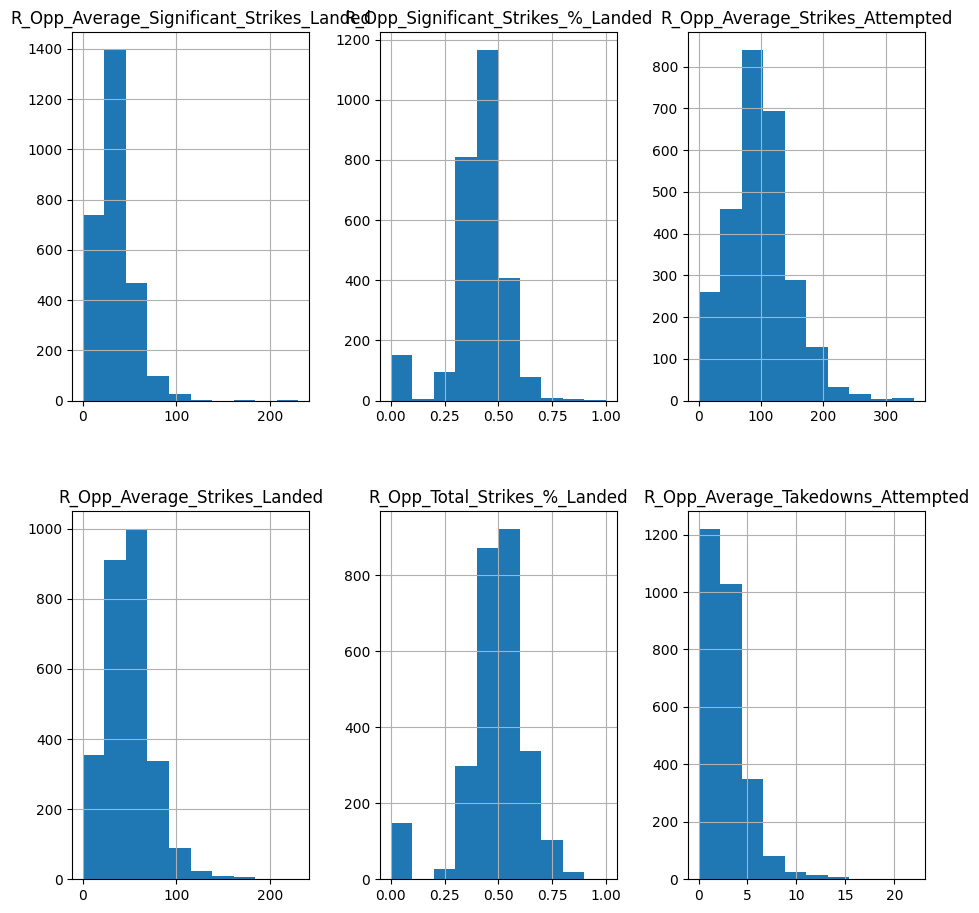

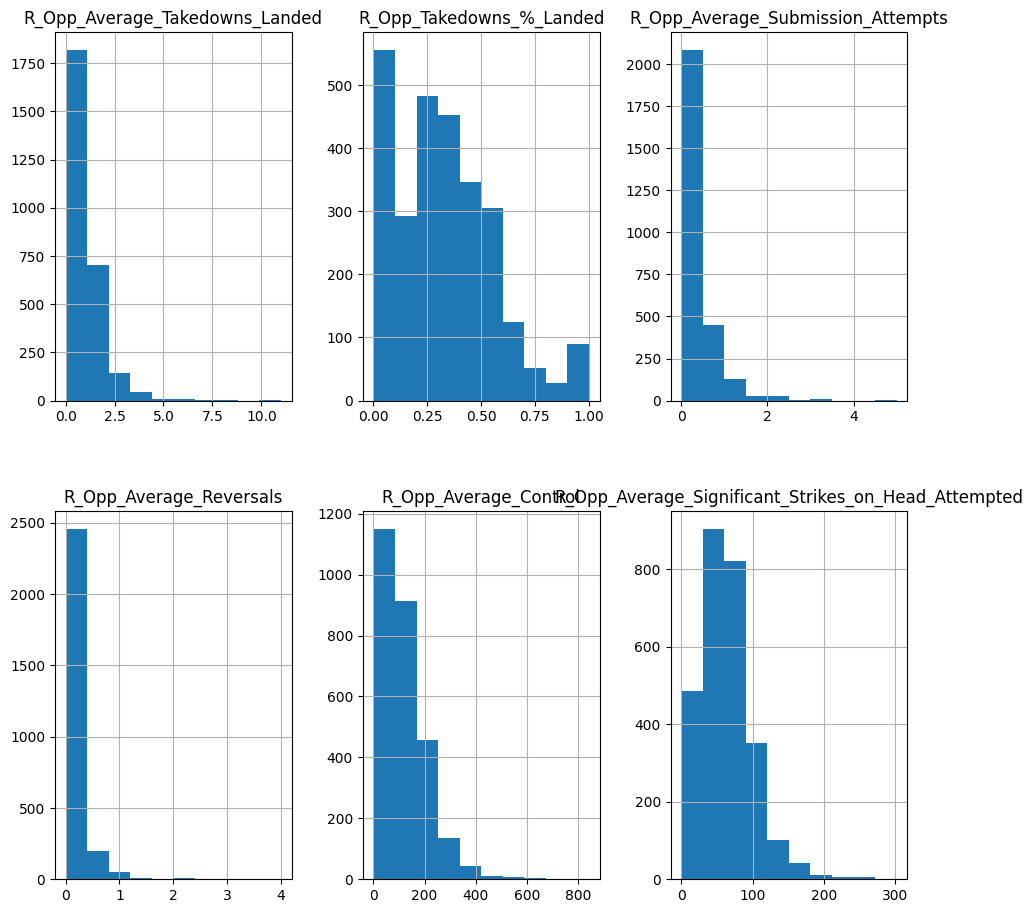

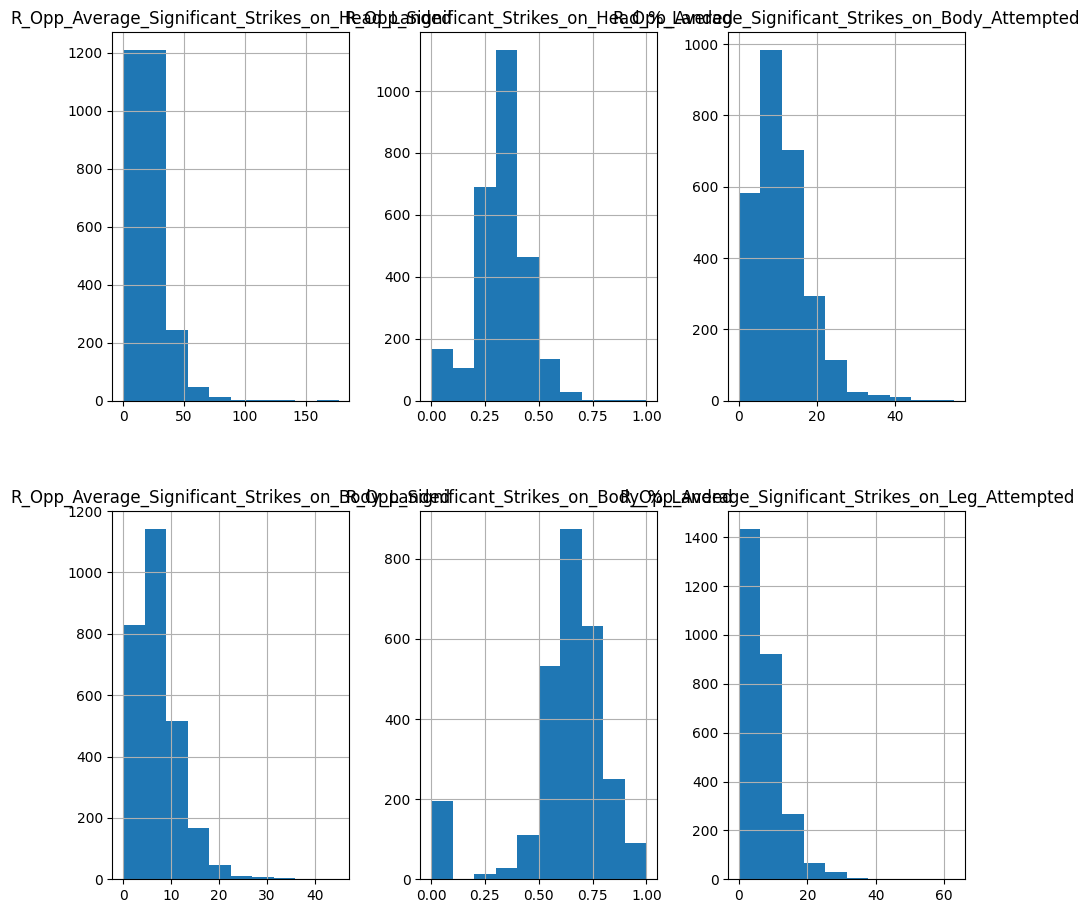

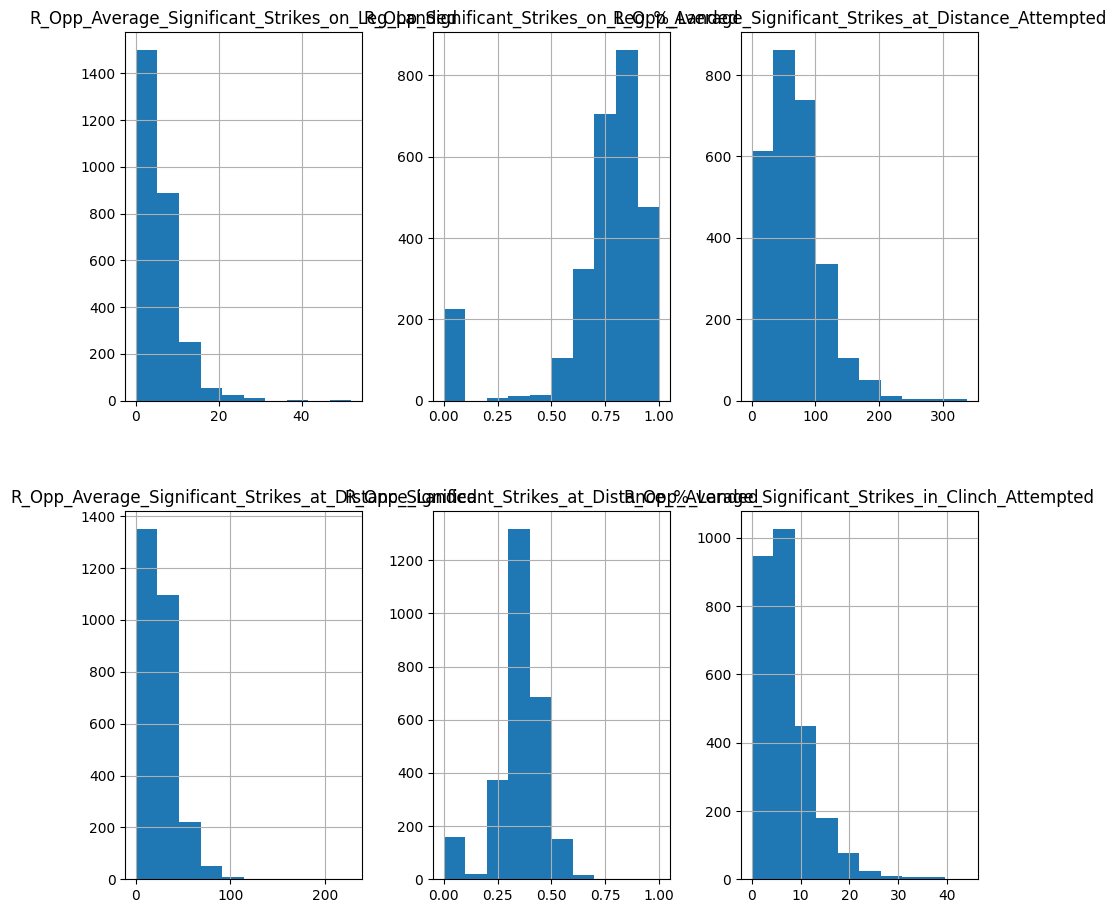

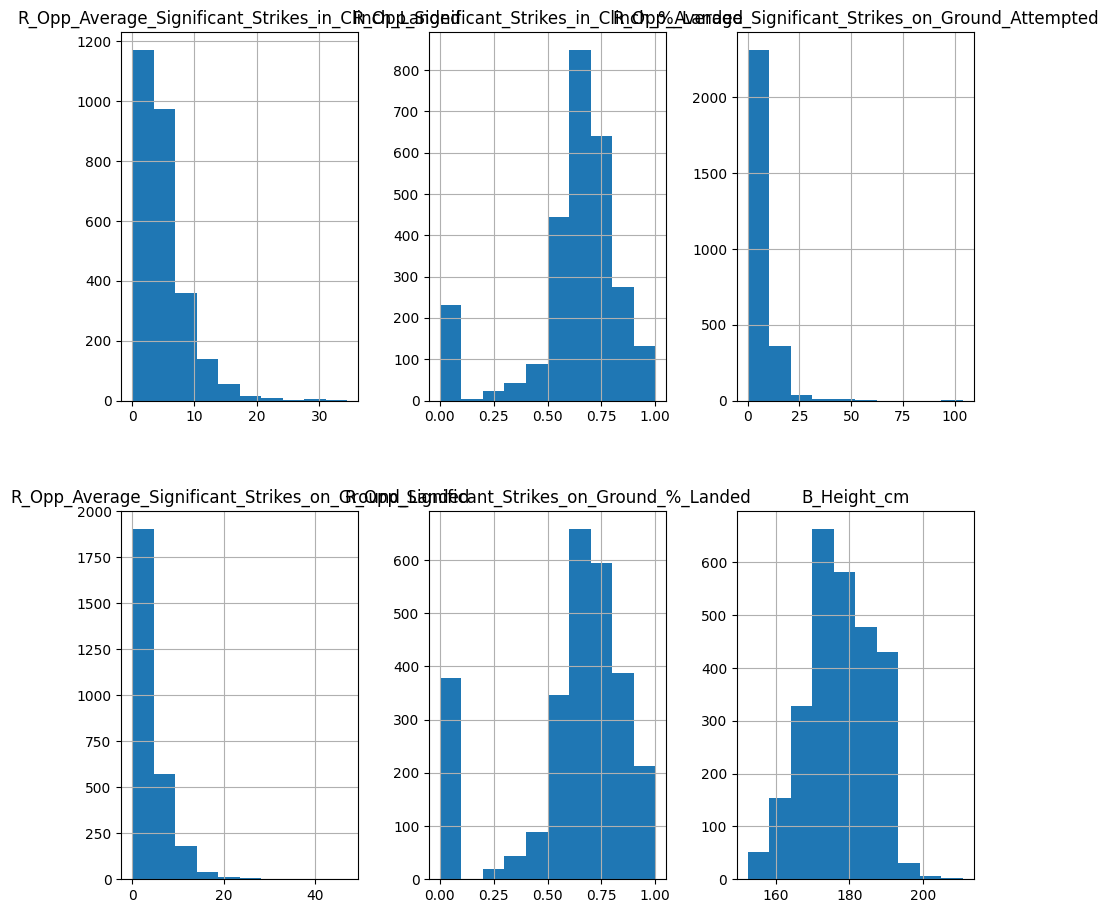

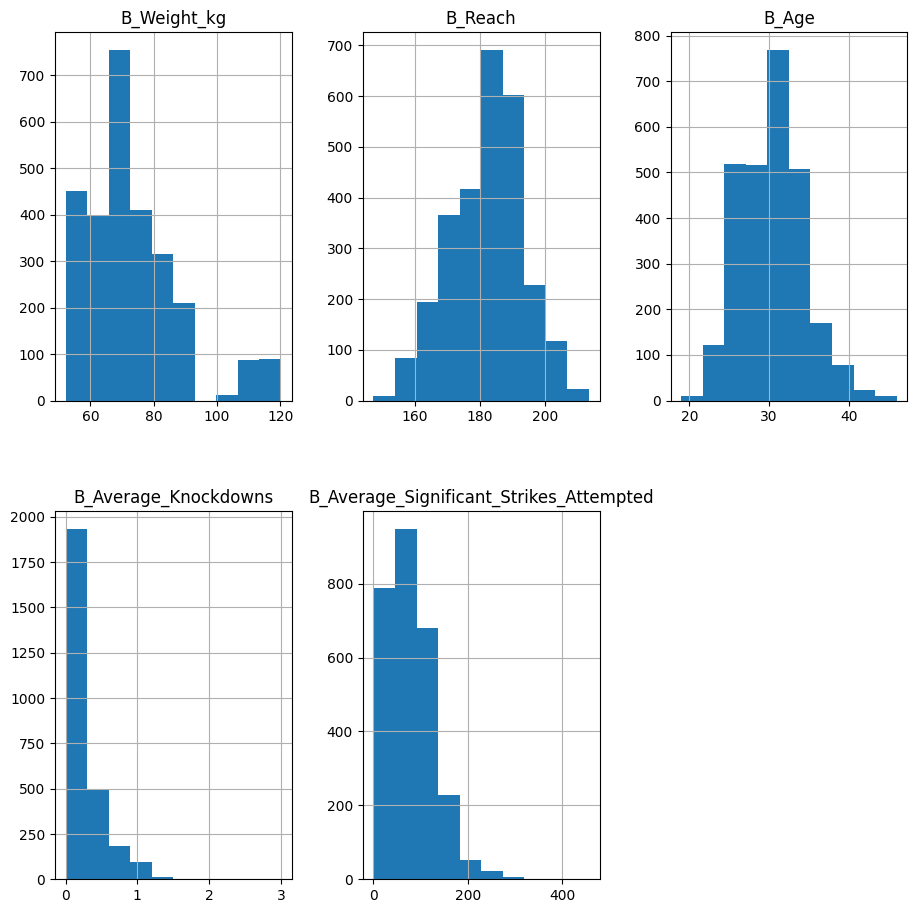

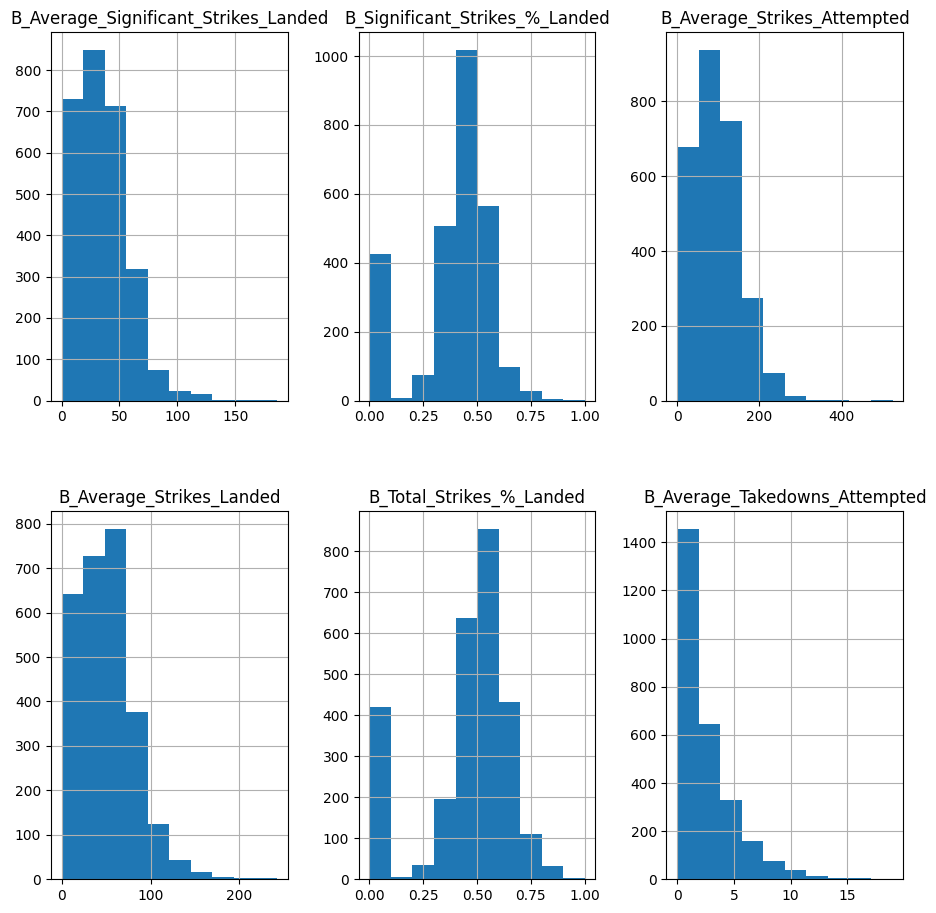

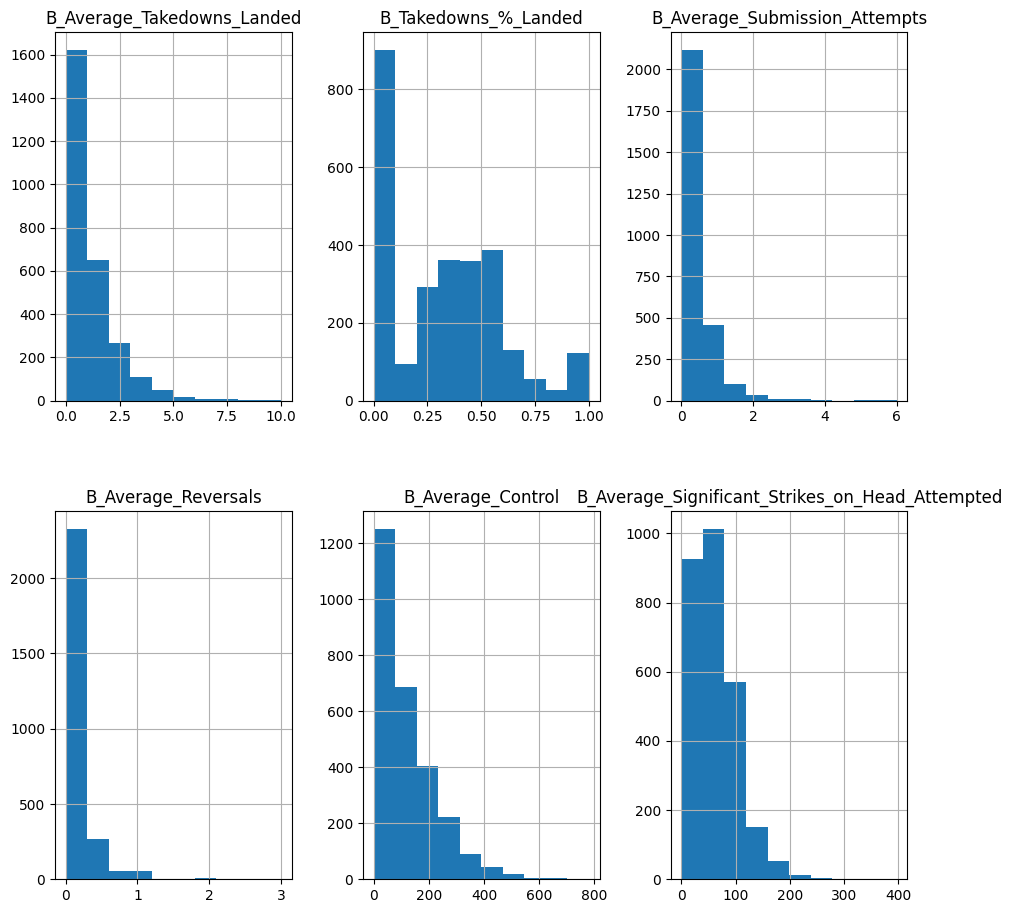

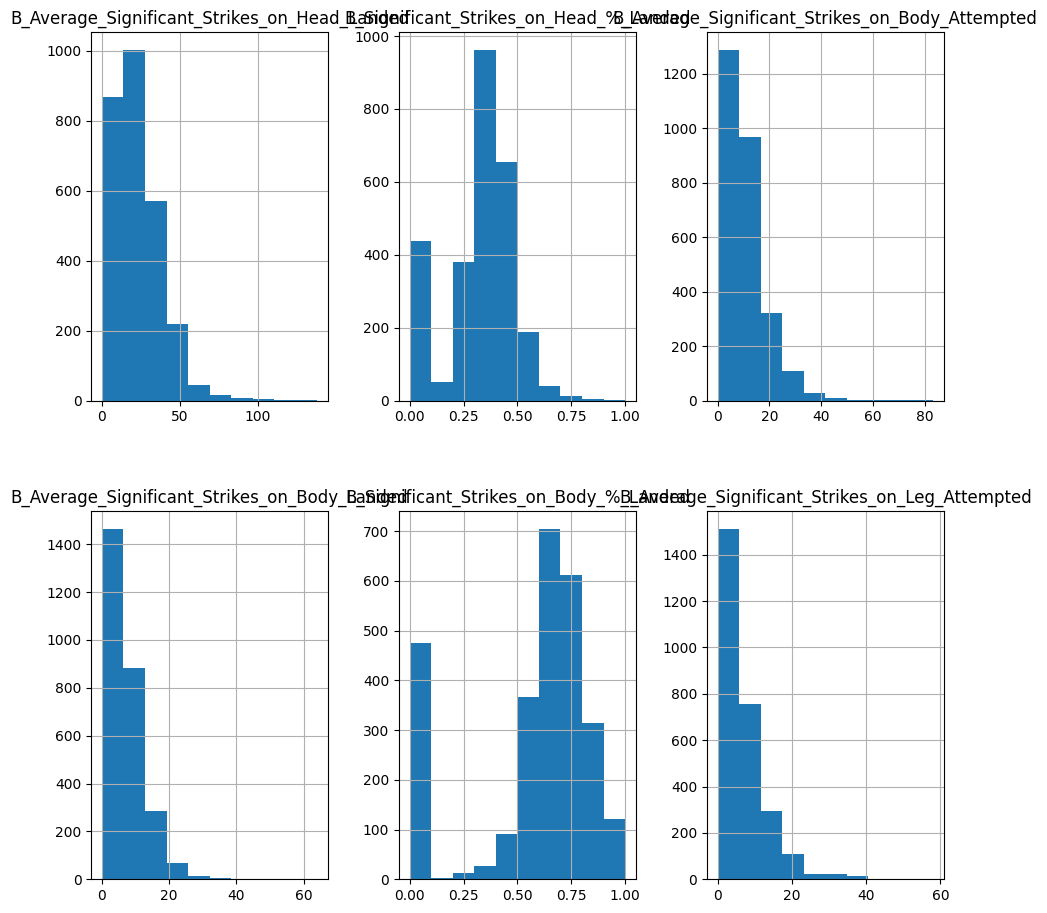

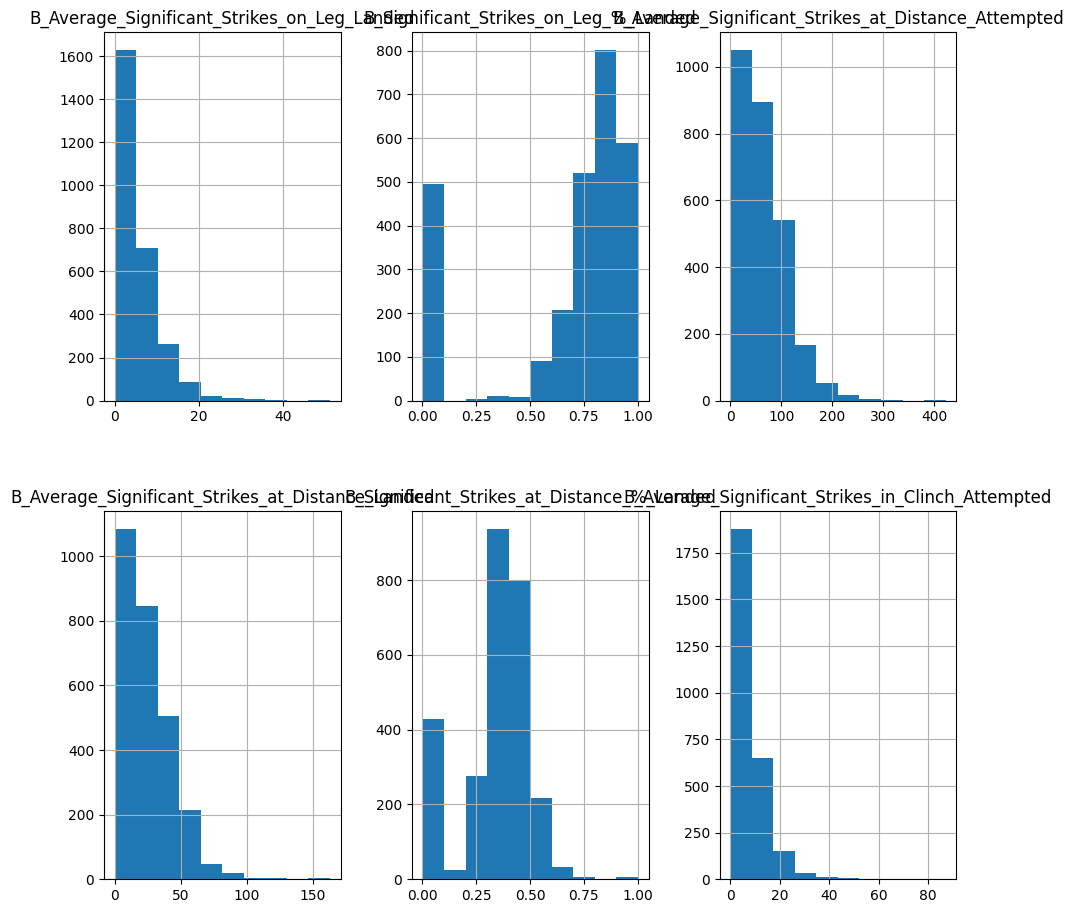

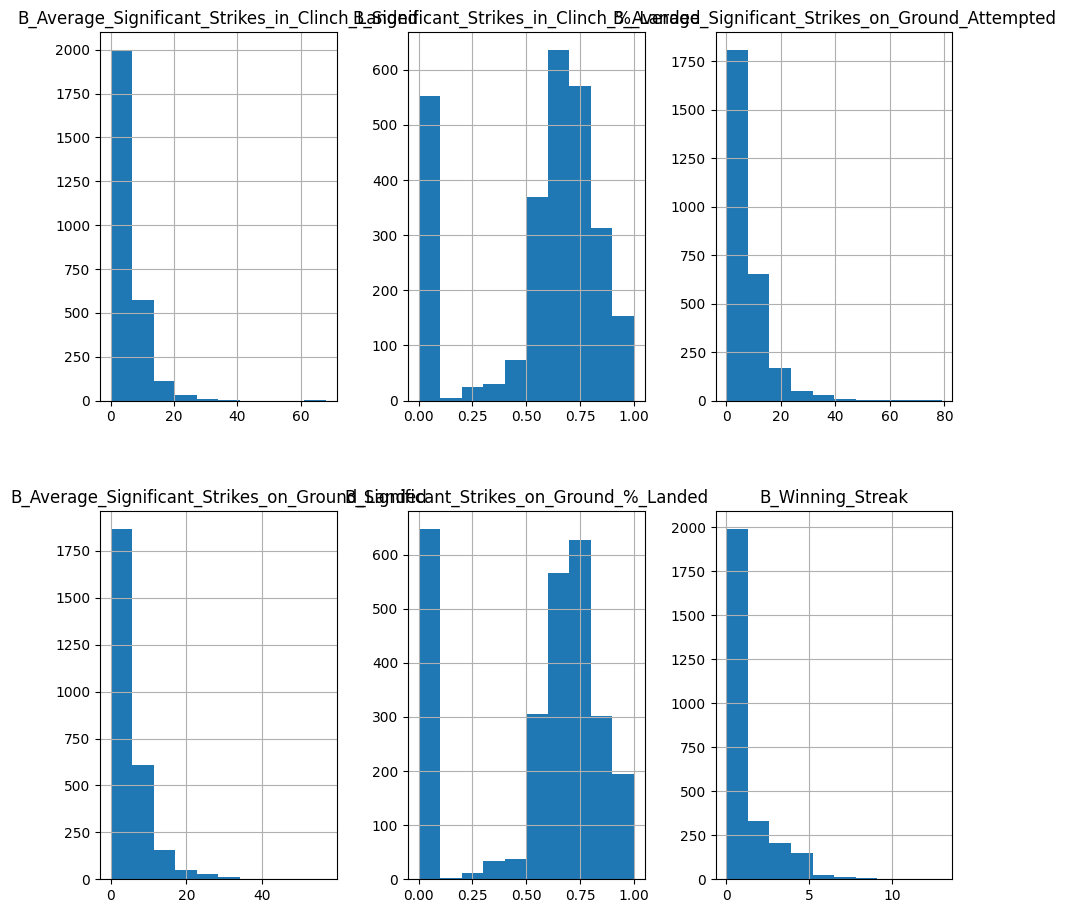

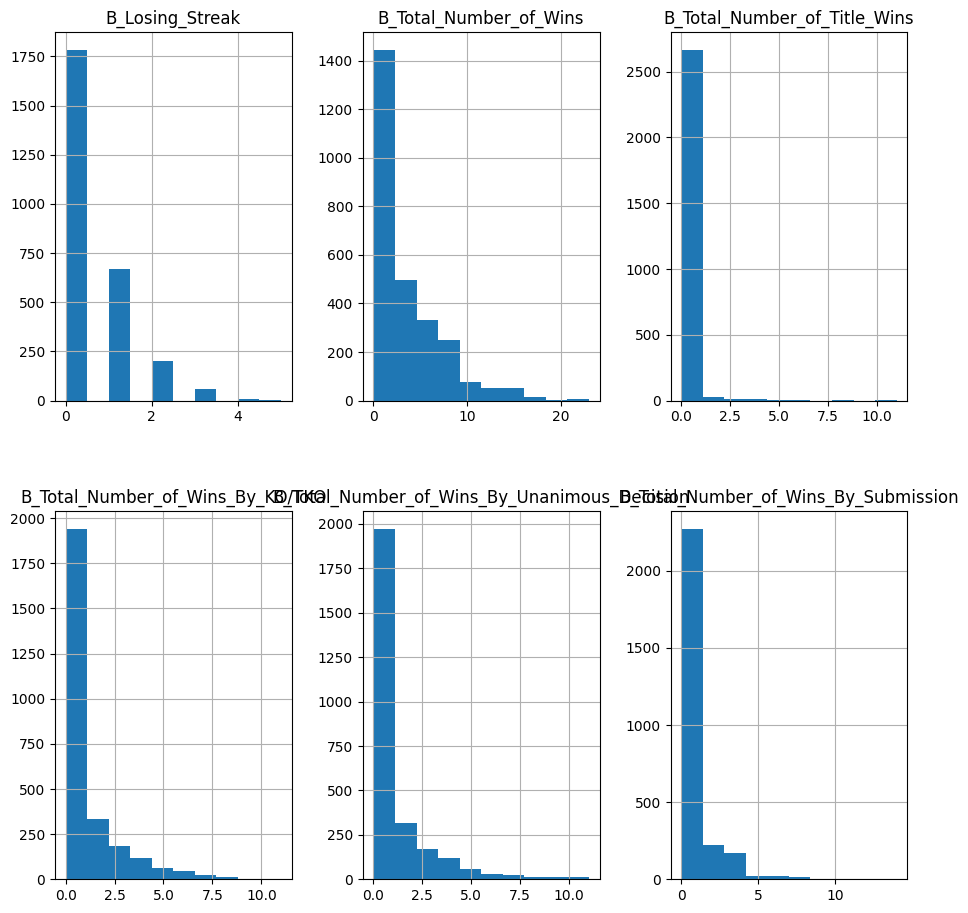

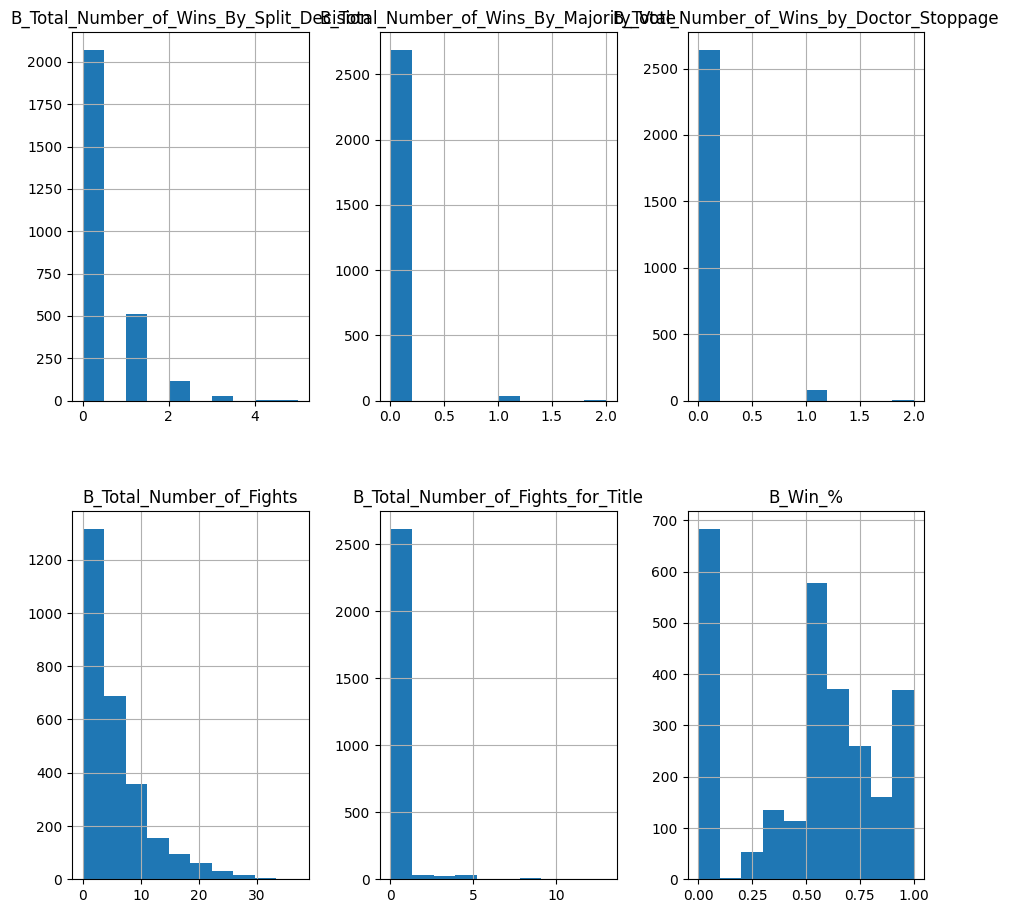

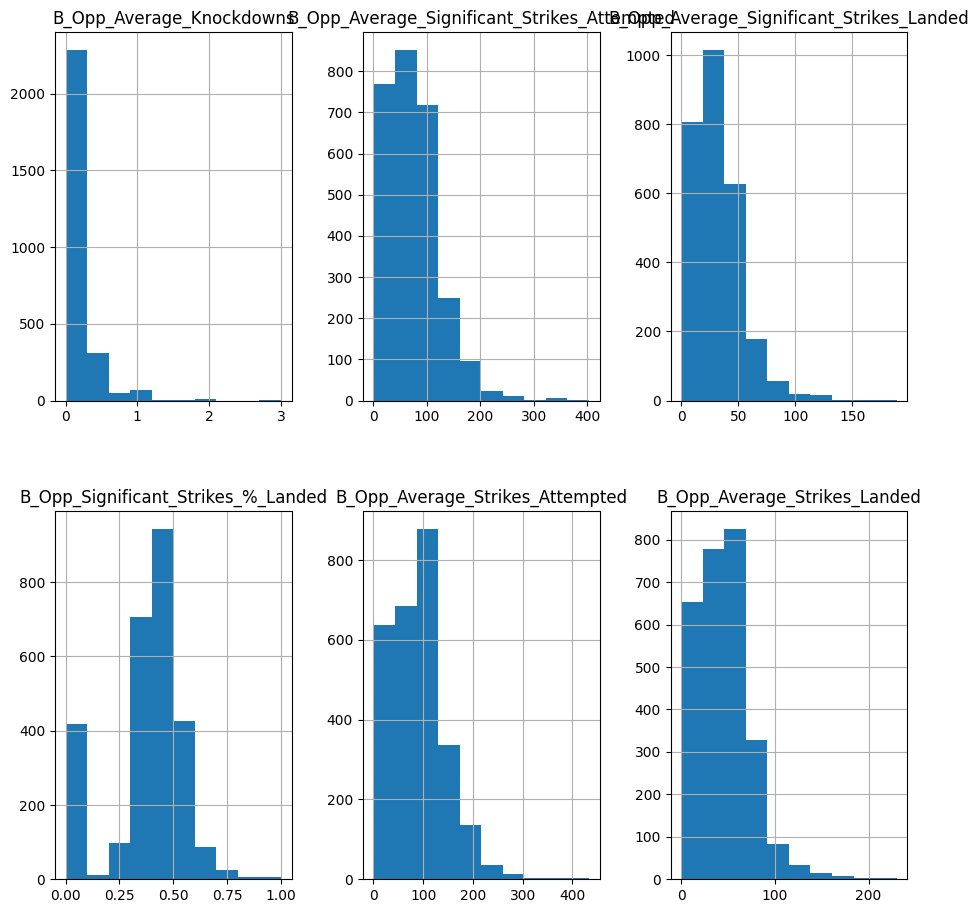

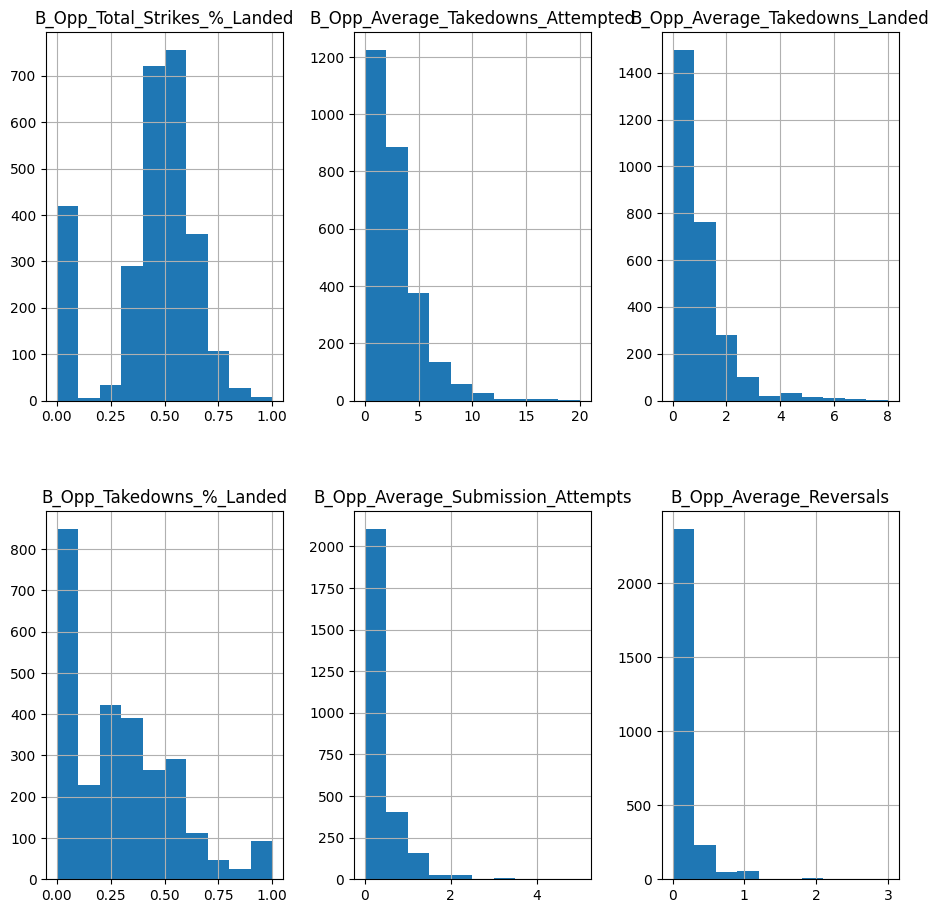

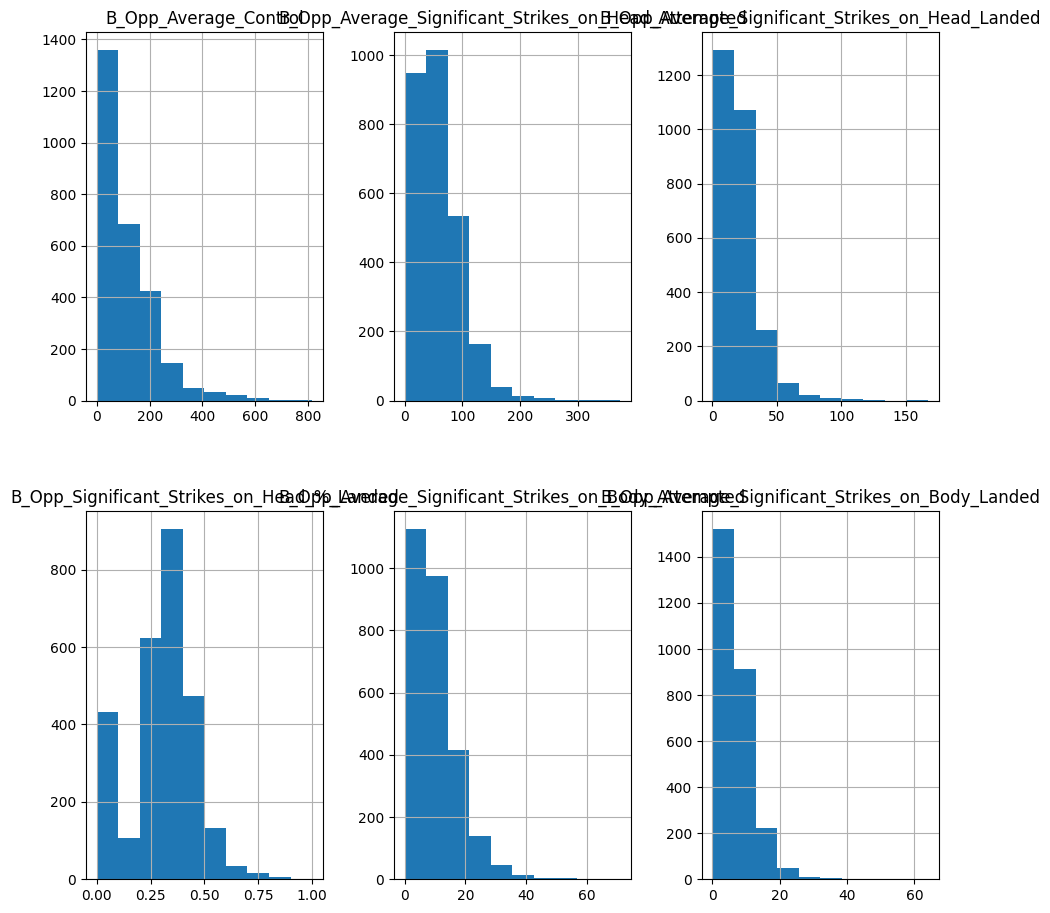

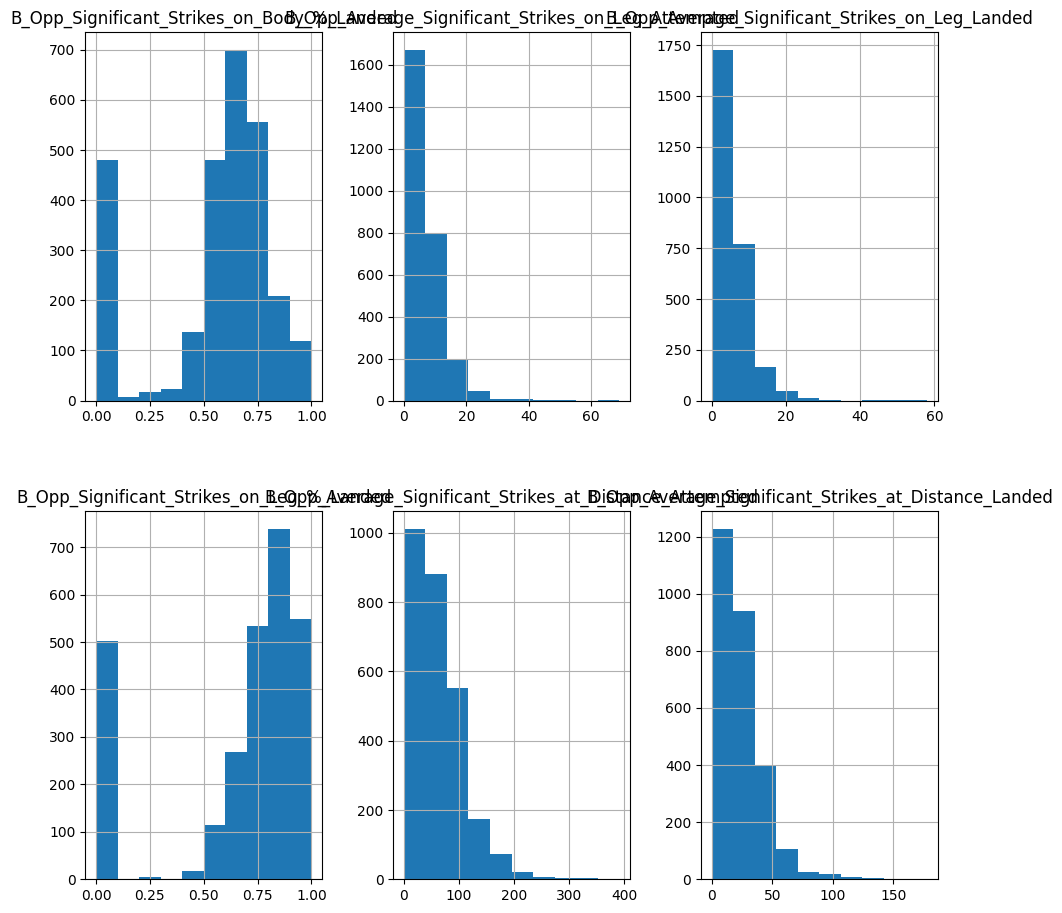

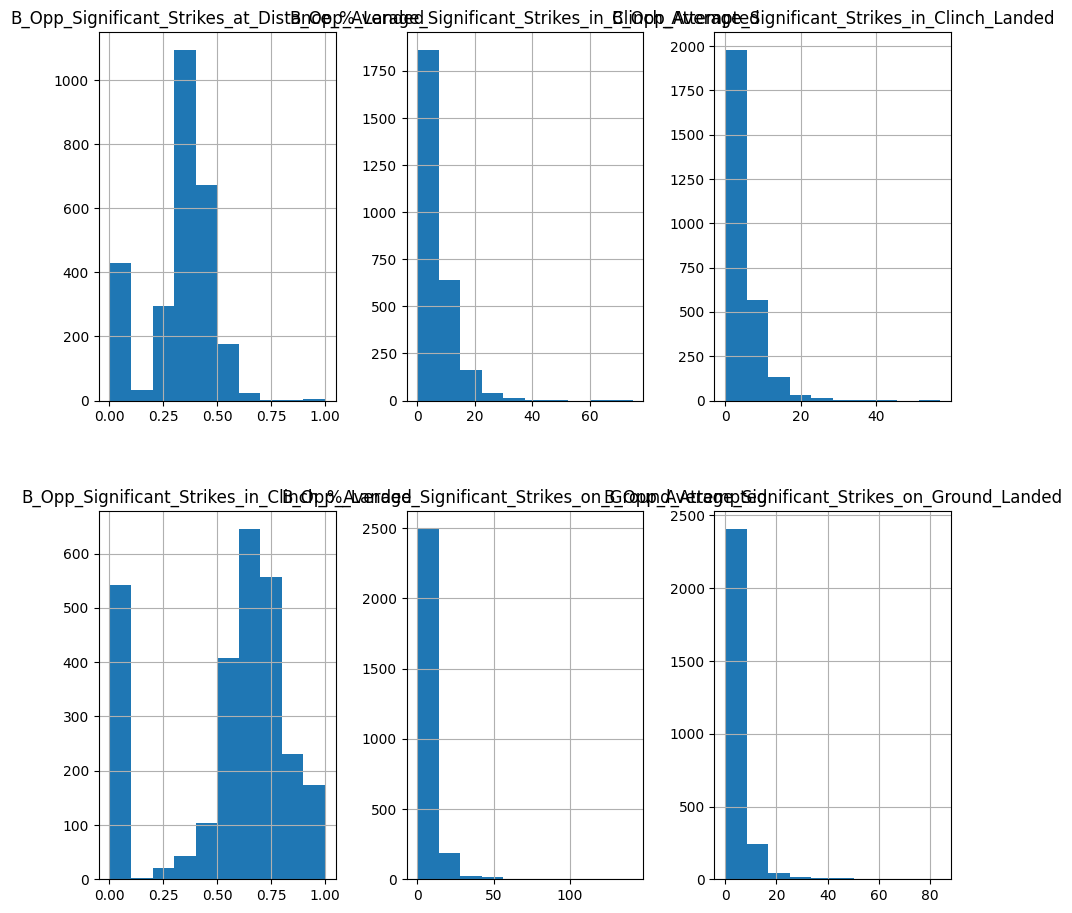

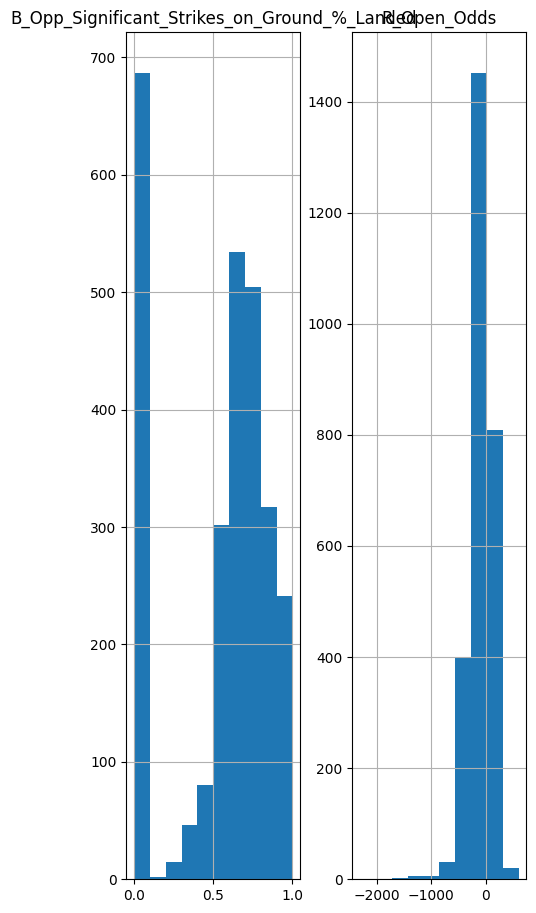

In [46]:
# Set the random seed
random.seed(2137)
np.random.seed(2137)

Y_all = dropdata['Winner']
X_all = dropdata.drop(['Winner'], axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.25, random_state=2023)

# standardizer for numerical columns
transformer_num = Pipeline([
    ('scaler', StandardScaler())
])

# standardizer for categorical columns
transformer_cat = Pipeline([
    ('scaler', OneHotEncoder())
])

# jumping into using these into the preprocessor for all features:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', transformer_num, objecttypes_num),
        ('cat', transformer_cat, objecttypes_cat)   # no 'Winner' encoded
], remainder='passthrough')

# the standardization should be based on the training set, hence we obtain the relevant parameters:
preprocessor.fit_transform(X_train)


## Perceptron:

The Perceptron is another simple classification algorithm suitable for large scale learning. By default:

        It does not require a learning rate.

        It is not regularized (penalized).

        It updates its model only on mistakes.

The last characteristic implies that the Perceptron is slightly faster to train than SGD with the hinge loss and that the resulting models are sparser.

- Linearly separable

In [72]:
# starting the timer to see how much time it takes
start_time = time.time()

# Let's define the model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('imputer', KNNImputer()),
    #('selector', SelectKBest()),
    ('model', Perceptron(random_state=2023))
])


# Define the parameter grid
param_grid = {
    #'selector__k': [5, 10, 20, 30, 50, 70, 90, 110],
    'model__penalty': ['l1', 'l2', 'elasticnet', None],
    'model__alpha': [0.0001, 0.001, 0.01, 0.1],
    'model__max_iter': [50, 100, 150],
    'model__tol': [10, 1, 0.1, 0.01]
}

# create the grid search object
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=3, verbose=2)

# fit the grid search object to the data
grid_search.fit(X_train, Y_train)

# evaluate the best model on the test set
score = grid_search.score(X_test, Y_test)

# stopping the timer and seeing the result: ------------------------
end_time = time.time()

print('Accuracy on the test set: ', score)
print('\nBest parameters after the grid search: ', grid_search.best_params_)
print("\nTime taken for model to learn: ", end_time - start_time, " seconds")

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Accuracy on the test set:  0.4175824175824176

Best parameters after the grid search:  {'model__alpha': 0.1, 'model__max_iter': 50, 'model__penalty': 'elasticnet', 'model__tol': 1}

Time taken for model to learn:  82.5486741065979  seconds


In [ ]:
# save the model to disk using pickle
if input('Are you sure you want to run this cell? It will overwrite current best model. Y/N: ') == 'Y':
    with open('trained_models/best_perceptron_model.pkl', 'wb') as f:
        pickle.dump(grid_search, f)

In [87]:
# load the best model from disk using pickle
with open('trained_models/best_perceptron_model.pkl', 'rb') as f:
    model = pickle.load(f)

print('Best parameters after the grid search: ', model.best_params_)

Best parameters after the grid search:  {'model__alpha': 0.001, 'model__max_iter': 100, 'model__penalty': 'elasticnet', 'model__tol': 1, 'selector__k': 5}


In [44]:
# printing the initial, preprocessed columns:
print('Columns in X_train: ', preprocessor.get_feature_names_out())

# Get the selected feature indices after SelectKBest() in the best estimator
selected_feature_indices = model.best_estimator_.named_steps['selector'].get_support(indices=True)

# Get the column names of the selected features
selected_feature_names = preprocessor.get_feature_names_out()[selected_feature_indices]
print('\nColumns after feature selection: ', selected_feature_names)

Columns in X_train:  ['num__R_Height_cm' 'num__R_Weight_kg' 'num__R_Reach' 'num__R_Age'
 'num__R_Average_Knockdowns'
 'num__R_Average_Significant_Strikes_Attempted'
 'num__R_Average_Significant_Strikes_Landed'
 'num__R_Significant_Strikes_%_Landed' 'num__R_Average_Strikes_Attempted'
 'num__R_Average_Strikes_Landed' 'num__R_Total_Strikes_%_Landed'
 'num__R_Average_Takedowns_Attempted' 'num__R_Average_Takedowns_Landed'
 'num__R_Takedowns_%_Landed' 'num__R_Average_Submission_Attempts'
 'num__R_Average_Reversals' 'num__R_Average_Control'
 'num__R_Average_Significant_Strikes_on_Head_Attempted'
 'num__R_Average_Significant_Strikes_on_Head_Landed'
 'num__R_Significant_Strikes_on_Head_%_Landed'
 'num__R_Average_Significant_Strikes_on_Body_Attempted'
 'num__R_Average_Significant_Strikes_on_Body_Landed'
 'num__R_Significant_Strikes_on_Body_%_Landed'
 'num__R_Average_Significant_Strikes_on_Leg_Attempted'
 'num__R_Average_Significant_Strikes_on_Leg_Landed'
 'num__R_Significant_Strikes_on_Leg_%_Lan

In [45]:
# storing accuracy score:
acc_sco = accuracy_score(Y_test, model.predict(X_test)) 

# storing accuracy score:
acc_sco = accuracy_score(Y_test, model.predict(X_test)) 

# construction confusion matrix
cm = conf_mat(model, Y_test)

# store model results in tuned_models dictionary

print('Accuracy on the test set: ',acc_sco)
tuned_models['Perceptron'] = {'accuracy': acc_sco, 'model': model, 'confusion_matrix': cm}

# store model results in tuned_models dictionary

tuned_models['Perceptron'] = {'accuracy': acc_sco, 'model': model, 'confusion_matrix': cm}

KeyError: "['R_Total_Knockdowns', 'R_Total_Significant_Strikes_Attempted', 'R_Total_Significant_Strikes_Landed', 'R_Total_Strikes_Attempted', 'R_Total_Strikes_Landed', 'R_Total_Takedowns_Attempted', 'R_Total_Takedowns_Landed', 'R_Total_Submission_Attempts', 'R_Total_Reversals', 'R_Total_Control', 'R_Total_Significant_Strikes_on_Head_Attempted', 'R_Total_Significant_Strikes_on_Head_Landed', 'R_Total_Significant_Strikes_on_Head_%_Landed', 'R_Total_Significant_Strikes_on_Body_Attempted', 'R_Total_Significant_Strikes_on_Body_Landed', 'R_Total_Significant_Strikes_on_Body_%_Landed', 'R_Total_Significant_Strikes_on_Leg_Attempted', 'R_Total_Significant_Strikes_on_Leg_Landed', 'R_Total_Significant_Strikes_on_Leg_%_Landed', 'R_Total_Significant_Strikes_at_Distance_Attempted', 'R_Total_Significant_Strikes_at_Distance_Landed', 'R_Total_Significant_Strikes_at_Distance_%_Landed', 'R_Total_Significant_Strikes_in_Clinch_Attempted', 'R_Total_Significant_Strikes_in_Clinch_Landed', 'R_Total_Significant_Strikes_in_Clinch_%_Landed', 'R_Total_Significant_Strikes_on_Ground_Attempted', 'R_Total_Significant_Strikes_on_Ground_Landed', 'R_Total_Significant_Strikes_on_Ground_%_Landed', 'B_Total_Knockdowns', 'B_Total_Significant_Strikes_Attempted', 'B_Total_Significant_Strikes_Landed', 'B_Total_Strikes_Attempted', 'B_Total_Strikes_Landed', 'B_Total_Takedowns_Attempted', 'B_Total_Takedowns_Landed', 'B_Total_Submission_Attempts', 'B_Total_Reversals', 'B_Total_Control', 'B_Total_Significant_Strikes_on_Head_Attempted', 'B_Total_Significant_Strikes_on_Head_Landed', 'B_Total_Significant_Strikes_on_Head_%_Landed', 'B_Total_Significant_Strikes_on_Body_Attempted', 'B_Total_Significant_Strikes_on_Body_Landed', 'B_Total_Significant_Strikes_on_Body_%_Landed', 'B_Total_Significant_Strikes_on_Leg_Attempted', 'B_Total_Significant_Strikes_on_Leg_Landed', 'B_Total_Significant_Strikes_on_Leg_%_Landed', 'B_Total_Significant_Strikes_at_Distance_Attempted', 'B_Total_Significant_Strikes_at_Distance_Landed', 'B_Total_Significant_Strikes_at_Distance_%_Landed', 'B_Total_Significant_Strikes_in_Clinch_Attempted', 'B_Total_Significant_Strikes_in_Clinch_Landed', 'B_Total_Significant_Strikes_in_Clinch_%_Landed', 'B_Total_Significant_Strikes_on_Ground_Attempted', 'B_Total_Significant_Strikes_on_Ground_Landed', 'B_Total_Significant_Strikes_on_Ground_%_Landed'] not in index"

## Random Forest Classifier

A random forest classifier.

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is controlled with the max_samples parameter if bootstrap=True (default), otherwise the whole dataset is used to build each tree.

In [61]:
# starting the timer to see how much time it takes
start_time = time.time()

# Let's define the model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('imputer', KNNImputer()),
    #('selector', SelectKBest()),
    ('model', RandomForestClassifier(random_state=2023))
])


# Define the parameter grid
param_grid = {
    #'selector__k': [5, 15, 35],
    'model__n_estimators': [350],
    'model__criterion': ['entropy', 'gini'],
    'model__max_depth': [30, 40],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [2, 4],
    'model__max_features': ['sqrt']
}

# create the grid search object
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, verbose=2, n_jobs=4)

# fit the grid search object to the data
grid_search.fit(X_train, Y_train)

# evaluate the best model on the test set
score = grid_search.score(X_test, Y_test)

# stopping the timer and seeing the result: ------------------------
end_time = time.time()

print('Accuracy on the test set: ', score)
print('\nBest parameters after the grid search: ', grid_search.best_params_)
print("\nTime taken for model to learn: ", end_time - start_time, " seconds")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Accuracy on the test set:  0.610989010989011

Best parameters after the grid search:  {'model__criterion': 'gini', 'model__max_depth': 30, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 350}

Time taken for model to learn:  337.82582569122314  seconds


In [ ]:
# save the model to disk using pickle
if input('Are you sure you want to run this cell? It will overwrite current best model. Y/N: ') == 'Y':
    with open('trained_models/best_random_forest_model.pkl', 'wb') as f:
        pickle.dump(grid_search, f)

In [50]:
# load the best model from disk using pickle
with open('trained_models/best_random_forest_model.pkl', 'rb') as f:
    model = pickle.load(f)
 
print('Best parameters after the grid search: ', model.best_params_)

Best parameters after the grid search:  {'model__criterion': 'entropy', 'model__max_depth': 30, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 250, 'selector__k': 50}


In [ ]:
# printing the initial, preprocessed columns:
print('Columns in X_train: ', preprocessor.get_feature_names_out())

# Get the selected feature indices after SelectKBest() in the best estimator
selected_feature_indices = model.best_estimator_.named_steps['selector'].get_support(indices=True)

# Get the column names of the selected features
selected_feature_names = preprocessor.get_feature_names_out()[selected_feature_indices]
print('\nColumns after feature selection: ', selected_feature_names)

In [ ]:
# storing accuracy score:
acc_sco = accuracy_score(Y_test, model.predict(X_test)) 

# construction confusion matrix
cm = conf_mat(model, Y_test)

# store model results in tuned_models dictionary

print('Accuracy on the test set: ', acc_sco)
tuned_models['Random_Forest'] = {'accuracy': acc_sco, 'model': model, 'confusion_matrix': cm}

## Decision Tree Classifier

A decision tree classifier.

In [49]:
# starting the timer to see how much time it takes
start_time = time.time()

# Let's define the model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('Imputer', KNNImputer()),
    ('selector', SelectKBest()),
    ('model', DecisionTreeClassifier(random_state=2023))
])


# Define the parameter grid
param_grid = {
    'selector__k': [4, 5, 10, 20, 50, 70],
    'model__criterion': ['gini', 'entropy', 'log_loss'],
    'model__max_depth': [2, 5],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['sqrt', 'log2']
}

# create the grid search object
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, verbose=2, n_jobs=3)

# fit the grid search object to the data
grid_search.fit(X_train, Y_train)

# evaluate the best model on the test set
score = grid_search.score(X_test, Y_test)

# stopping the timer and seeing the result: ------------------------
end_time = time.time()

print('Accuracy on the test set: ', score)
print('\nBest parameters after the grid search: ', grid_search.best_params_)
print("\nTime taken for model to learn: ", end_time - start_time, " seconds")

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Accuracy on the test set:  0.6329670329670329

Best parameters after the grid search:  {'model__criterion': 'gini', 'model__max_depth': 5, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'selector__k': 5}

Time taken for model to learn:  92.46358919143677  seconds


In [ ]:
# save the model to disk using pickle
if input('Are you sure you want to run this cell? It will overwrite current best model. Y/N: ') == 'Y':
    with open('trained_models/best_decision_tree_model.pkl', 'wb') as f:
        pickle.dump(grid_search, f)

In [27]:
# load the best model from disk using pickle
with open('trained_models/best_decision_tree_model.pkl', 'rb') as f:
    model = pickle.load(f)
 
print('Best parameters after the grid search: ', model.best_params_)

Best parameters after the grid search:  {'model__criterion': 'log_loss', 'model__max_depth': 5, 'model__max_features': 'log2', 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'selector__k': 3}


In [28]:
# printing the initial, preprocessed columns:
print('Columns in X_train: ', preprocessor.get_feature_names_out())

# Get the selected feature indices after SelectKBest() in the best estimator
selected_feature_indices = model.best_estimator_.named_steps['selector'].get_support(indices=True)

# Get the column names of the selected features
selected_feature_names = preprocessor.get_feature_names_out()[selected_feature_indices]
print('\nColumns after feature selection: ', selected_feature_names)

Columns in X_train:  ['num__R_Height_cm' 'num__R_Weight_kg' 'num__R_Reach' 'num__R_Age'
 'num__R_Average_Knockdowns'
 'num__R_Average_Significant_Strikes_Attempted'
 'num__R_Average_Significant_Strikes_Landed'
 'num__R_Significant_Strikes_%_Landed' 'num__R_Average_Strikes_Attempted'
 'num__R_Average_Strikes_Landed' 'num__R_Total_Strikes_%_Landed'
 'num__R_Average_Takedowns_Attempted' 'num__R_Average_Takedowns_Landed'
 'num__R_Takedowns_%_Landed' 'num__R_Average_Submission_Attempts'
 'num__R_Average_Reversals' 'num__R_Average_Control'
 'num__R_Average_Significant_Strikes_on_Head_Attempted'
 'num__R_Average_Significant_Strikes_on_Head_Landed'
 'num__R_Significant_Strikes_on_Head_%_Landed'
 'num__R_Average_Significant_Strikes_on_Body_Attempted'
 'num__R_Average_Significant_Strikes_on_Body_Landed'
 'num__R_Significant_Strikes_on_Body_%_Landed'
 'num__R_Average_Significant_Strikes_on_Leg_Attempted'
 'num__R_Average_Significant_Strikes_on_Leg_Landed'
 'num__R_Significant_Strikes_on_Leg_%_Lan

In [ ]:
# storing accuracy score:
acc_sco = accuracy_score(Y_test, model.predict(X_test)) 

# construction confusion matrix
cm = conf_mat(model, Y_test)

# store model results in tuned_models dictionary

print('Accuracy on the test set: ',acc_sco)
tuned_models['Decision_Tree'] = {'accuracy': acc_sco, 'model': model, 'confusion_matrix': cm}

## Stochastic Gradient Descent (SGD) Classifier

A linear classifier with SGD training. Default implementation uses the loss='hinge' used for linear SVM

In [64]:
# starting the timer to see how much time it takes
start_time = time.time()

# Let's define the model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('imputer', KNNImputer()),
    #('selector', SelectKBest()),
    ('model', SGDClassifier(random_state=2023))
])


# Define the parameter grid
param_grid = {
    #'selector__k': [5, 10, 20, 40, 60],
    'model__alpha': [0.0001, 0.001, 0.01, 0.1],
    'model__penalty': ['l1', 'l2', 'elasticnet'],
    'model__max_iter': [50, 100, 200, 300, 400],
    'model__tol': [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
}
# create the grid search object
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)

# fit the grid search object to the data
grid_search.fit(X_train, Y_train)

# evaluate the best model on the test set
score = grid_search.score(X_test, Y_test)

# stopping the timer and seeing the result: ------------------------
end_time = time.time()

print('Accuracy on the test set: ', score)
print('\nBest parameters after the grid search: ', grid_search.best_params_)
print("\nTime taken for model to learn: ", end_time - start_time, " seconds")

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Accuracy on the test set:  0.6417582417582418

Best parameters after the grid search:  {'model__alpha': 0.01, 'model__max_iter': 100, 'model__penalty': 'elasticnet', 'model__tol': 1e-06}

Time taken for model to learn:  332.4405725002289  seconds


c:\users\mewash\desktop\datascienceprojectpython\myenv\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [ ]:
# save the model to disk using pickle
if input('Are you sure you want to run this cell? It will overwrite current best model. Y/N: ') == 'Y':
    with open('trained_models/best_SGDClassfier_model.pkl', 'wb') as f:
        pickle.dump(grid_search, f)

In [ ]:
# load the best model from disk using pickle
with open('trained_models/best_SGDClassfier_model.pkl', 'rb') as f:
    model = pickle.load(f)
 
print('Best parameters after the grid search: ', model.best_params_)

In [ ]:
# printing the initial, preprocessed columns:
print('Columns in X_train: ', preprocessor.get_feature_names_out())

# Get the selected feature indices after SelectKBest() in the best estimator
selected_feature_indices = model.best_estimator_.named_steps['selector'].get_support(indices=True)

# Get the column names of the selected features
selected_feature_names = preprocessor.get_feature_names_out()[selected_feature_indices]
print('\nColumns after feature selection: ', selected_feature_names)

In [ ]:
# storing accuracy score:
acc_sco = accuracy_score(Y_test, model.predict(X_test)) 

# construction confusion matrix
cm = conf_mat(model, Y_test)

# store model results in tuned_models dictionary

print('Accuracy on the test set: ',acc_sco)
tuned_models['SGDClassfier'] = {'accuracy': acc_sco, 'model': model, 'confusion_matrix': cm}

## Linear SVC

Linear Support Vector Classification.

In [69]:
# starting the timer to see how much time it takes
start_time = time.time()

# Let's define the model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('imputer', KNNImputer()),
    #('selector', SelectKBest()),
    ('model', LinearSVC(random_state=2023))
])


# Define the parameter grid
param_grid = {
    #'selector__k': [40, 60, 70, 80],
    'model__loss': ['hinge', 'squared_hinge'],
    'model__C': [0.001, 0.01, 0.1, 1],
    'model__penalty': ['l1', 'l2'],
    'model__max_iter': [50, 100, 200],
    'model__tol': [1, 0.1, 0.01, 0.001, 0.0001]
}
# create the grid search object
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)

# fit the grid search object to the data
grid_search.fit(X_train, Y_train)

# evaluate the best model on the test set
score = grid_search.score(X_test, Y_test)

# stopping the timer and seeing the result: ------------------------
end_time = time.time()

print('Accuracy on the test set: ', score)
print('\nBest parameters after the grid search: ', grid_search.best_params_)
print("\nTime taken for model to learn: ", end_time - start_time, " seconds")

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


c:\users\mewash\desktop\datascienceprojectpython\myenv\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
600 fits failed out of a total of 1200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "c:\users\mewash\desktop\datascienceprojectpython\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\mewash\desktop\datascienceprojectpython\myenv\lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\users\mewash\desktop\datascienceprojectpython\myenv\li

Accuracy on the test set:  0.634065934065934

Best parameters after the grid search:  {'model__C': 0.01, 'model__loss': 'hinge', 'model__max_iter': 50, 'model__penalty': 'l2', 'model__tol': 0.01}

Time taken for model to learn:  91.37089395523071  seconds


c:\users\mewash\desktop\datascienceprojectpython\myenv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
# save the model to disk using pickle
if input('Are you sure you want to run this cell? It will overwrite current best model. Y/N: ') == 'Y':
    with open('trained_models/best_LinearSVC_model.pkl', 'wb') as f:
        pickle.dump(grid_search, f)

In [ ]:
# load the best model from disk using pickle
with open('trained_models/best_LinearSVC_model.pkl', 'rb') as f:
    model = pickle.load(f)
 
print('Best parameters after the grid search: ', model.best_params_)

In [ ]:
# printing the initial, preprocessed columns:
print('Columns in X_train: ', preprocessor.get_feature_names_out())

# Get the selected feature indices after SelectKBest() in the best estimator
selected_feature_indices = model.best_estimator_.named_steps['selector'].get_support(indices=True)

# Get the column names of the selected features
selected_feature_names = preprocessor.get_feature_names_out()[selected_feature_indices]
print('\nColumns after feature selection: ', selected_feature_names)

In [ ]:
# storing accuracy score:
acc_sco = accuracy_score(Y_test, model.predict(X_test)) 

# construction confusion matrix
cm = conf_mat(model, Y_test)

# store model results in tuned_models dictionary

print('Accuracy on the test set: ',acc_sco)
tuned_models['LinearSVC'] = {'accuracy': acc_sco, 'model': model, 'confusion_matrix': cm}

## Gaussian Naive Bayes

Gaussian Naive Bayes (GaussianNB)

In [70]:
# starting the timer to see how much time it takes
start_time = time.time()

# Let's define the model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('imputer', KNNImputer()),
    ('selector', SelectKBest()),
    ('model', GaussianNB())
])


# Define the parameter grid
param_grid = {
    'selector__k': [1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90],
}
# create the grid search object
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)

# fit the grid search object to the data
grid_search.fit(X_train, Y_train)

# evaluate the best model on the test set
score = grid_search.score(X_test, Y_test)

# stopping the timer and seeing the result: ------------------------
end_time = time.time()

print('Accuracy on the test set: ', score)
print('\nBest parameters after the grid search: ', grid_search.best_params_)
print("\nTime taken for model to learn: ", end_time - start_time, " seconds")

Fitting 5 folds for each of 14 candidates, totalling 70 fits
Accuracy on the test set:  0.6120879120879121

Best parameters after the grid search:  {'selector__k': 4}

Time taken for model to learn:  2.6757562160491943  seconds


In [ ]:
# save the model to disk using pickle
if input('Are you sure you want to run this cell? It will overwrite current best model. Y/N: ') == 'Y':
    with open('trained_models/best_GaussianNB_model.pkl', 'wb') as f:
        pickle.dump(grid_search, f)

In [ ]:
# load the best model from disk using pickle
with open('trained_models/best_GaussianNB_model.pkl', 'rb') as f:
    model = pickle.load(f)
 
print('Best parameters after the grid search: ', model.best_params_)

In [ ]:
# printing the initial, preprocessed columns:
print('Columns in X_train: ', preprocessor.get_feature_names_out())

# Get the selected feature indices after SelectKBest() in the best estimator
selected_feature_indices = model.best_estimator_.named_steps['selector'].get_support(indices=True)

# Get the column names of the selected features
selected_feature_names = preprocessor.get_feature_names_out()[selected_feature_indices]
print('\nColumns after feature selection: ', selected_feature_names)

In [ ]:
# storing accuracy score:
acc_sco = accuracy_score(Y_test, model.predict(X_test)) 

# construction confusion matrix
cm = conf_mat(model, Y_test)

# store model results in tuned_models dictionary

print('Accuracy on the test set: ',acc_sco)
tuned_models['Gaussian_NB'] = {'accuracy': acc_sco, 'model': model, 'confusion_matrix': cm}

## KNN

Classifier implementing the k-nearest neighbors vote.

In [71]:
# starting the timer to see how much time it takes
start_time = time.time()

# Let's define the model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('imputer', KNNImputer()),
    #('selector', SelectKBest()),
    ('model', KNeighborsClassifier())
])


# Define the parameter grid
param_grid = {
    #'selector__k': [5, 10, 20, 40, 60],
    'model__n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'model__weights': ['uniform', 'distance'],
    'model__metric': ['euclidean', 'manhattan', 'minkowski']
}
# create the grid search object
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)

# fit the grid search object to the data
grid_search.fit(X_train, Y_train)

# evaluate the best model on the test set
score = grid_search.score(X_test, Y_test)

# stopping the timer and seeing the result: ------------------------
end_time = time.time()

print('Accuracy on the test set: ', score)
print('\nBest parameters after the grid search: ', grid_search.best_params_)
print("\nTime taken for model to learn: ", end_time - start_time, " seconds")

Fitting 5 folds for each of 42 candidates, totalling 210 fits
Accuracy on the test set:  0.567032967032967

Best parameters after the grid search:  {'model__metric': 'euclidean', 'model__n_neighbors': 13, 'model__weights': 'distance'}

Time taken for model to learn:  11.814083576202393  seconds


In [ ]:
# save the model to disk using pickle
if input('Are you sure you want to run this cell? It will overwrite current best model. Y/N: ') == 'Y':
    with open('trained_models/best_KNN_model.pkl', 'wb') as f:
        pickle.dump(grid_search, f)

In [ ]:
# load the best model from disk using pickle
with open('trained_models/best_KNN_model.pkl', 'rb') as f:
    model = pickle.load(f)
 
print('Best parameters after the grid search: ', model.best_params_)

In [ ]:
# printing the initial, preprocessed columns:
print('Columns in X_train: ', preprocessor.get_feature_names_out())

# Get the selected feature indices after SelectKBest() in the best estimator
selected_feature_indices = model.best_estimator_.named_steps['selector'].get_support(indices=True)

# Get the column names of the selected features
selected_feature_names = preprocessor.get_feature_names_out()[selected_feature_indices]
print('\nColumns after feature selection: ', selected_feature_names)

In [ ]:
# storing accuracy score:
acc_sco = accuracy_score(Y_test, model.predict(X_test)) 

# construction confusion matrix
cm = conf_mat(model, Y_test)

# store model results in tuned_models dictionary

print('Accuracy on the test set: ',acc_sco)
tuned_models['KNN'] = {'accuracy': acc_sco, 'model': model, 'confusion_matrix': cm}

## Logistic Regression

Logistic Regression (aka logit, MaxEnt) classifier.


In [85]:
# starting the timer to see how much time it takes
start_time = time.time()

# Let's define the model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('imputer', KNNImputer()),
    #('selector', SelectKBest()),
    ('model', LogisticRegression(random_state=2023))
])


# Define the parameter grid
param_grid = {
    #'selector__k': [5, 10, 20, 40, 60],
    'model__penalty': ['l2'],
    'model__C': [0.001, 0.01, 0.1, 1.0],
    'model__solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
    'model__max_iter': [50, 100, 150, 200, 300],
    'model__tol': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
}
# create the grid search object
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, verbose=2, n_jobs=3)

# fit the grid search object to the data
grid_search.fit(X_train, Y_train)

# evaluate the best model on the test set
score = grid_search.score(X_test, Y_test)

# stopping the timer and seeing the result: ------------------------
end_time = time.time()

print('Accuracy on the test set: ', score)
print('\nBest parameters after the grid search: ', grid_search.best_params_)
print("\nTime taken for model to learn: ", end_time - start_time, " seconds")

Fitting 5 folds for each of 480 candidates, totalling 2400 fits
Accuracy on the test set:  0.6285714285714286

Best parameters after the grid search:  {'model__C': 0.01, 'model__max_iter': 50, 'model__penalty': 'l2', 'model__solver': 'saga', 'model__tol': 0.1}

Time taken for model to learn:  974.2978079319  seconds


In [ ]:
# save the model to disk using pickle
if input('Are you sure you want to run this cell? It will overwrite current best model. Y/N: ') == 'Y':
    with open('trained_models/best_logistic_regression.pkl', 'wb') as f:
        pickle.dump(grid_search, f)

In [86]:
# load the best model from disk using pickle
with open('trained_models/best_logistic_regression.pkl', 'rb') as f:
    model = pickle.load(f)
 
print('Best parameters after the grid search: ', model.best_params_)

FileNotFoundError: [Errno 2] No such file or directory: 'best_logistic_regression.pkl'

In [ ]:
# printing the initial, preprocessed columns:
print('Columns in X_train: ', preprocessor.get_feature_names_out())

# Get the selected feature indices after SelectKBest() in the best estimator
selected_feature_indices = model.best_estimator_.named_steps['selector'].get_support(indices=True)

# Get the column names of the selected features
selected_feature_names = preprocessor.get_feature_names_out()[selected_feature_indices]
print('\nColumns after feature selection: ', selected_feature_names)

In [ ]:
# storing accuracy score:
acc_sco = accuracy_score(Y_test, model.predict(X_test)) 

# construction confusion matrix
cm = conf_mat(model, Y_test)

# store model results in tuned_models dictionary

print('Accuracy on the test set: ',acc_sco)
tuned_models['Logistic_Regression'] = {'accuracy': acc_sco, 'model': model, 'confusion_matrix': cm}

# FINAL TUNEL MODELS COMPARISON

Here we assess the performance of each model


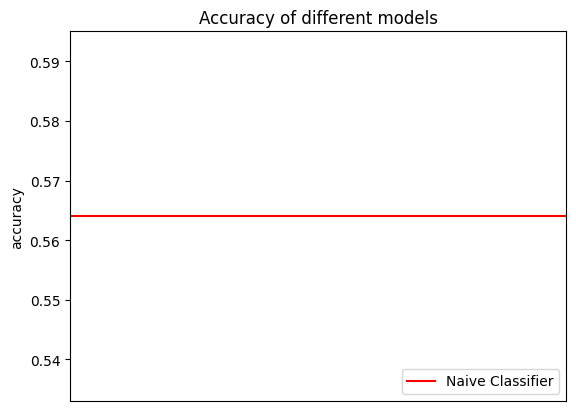

In [75]:
plot_models_acc(tuned_models, naive_classifier)

# NOTES

If the odds are available before the fight, then there is nothing inherently wrong with using them as a predictor. However, it's important to keep in mind that any information used for prediction should be available at the time the prediction is made. If the model is trained on data that includes information (such as odds) that would not be available at the time of prediction, then the model may overfit to the training data and perform poorly on new, unseen data.

Additionally, it's important to consider the ethics of using betting odds for predictive modeling. While it may be legal to use this information for research purposes, it could be seen as promoting gambling or taking advantage of vulnerable populations. It's important to approach this type of research with sensitivity and to consider the potential impacts of the research on society.